In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

##### Utility Functions

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [4]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

In [5]:
def generate_plotting_matrix(results_list, policy=None, ):
    daily_tests = list()
    inf = list()
    inf_low = list()
    inf_high = list()
    hosp = list()
    hosp_low = list()
    hosp_high = list()
    cornell_inf = list()
    cornell_inf_low = list()
    cornell_inf_high = list()
    cornell_hosp = list()
    cornell_hosp_low = list()
    cornell_hosp_high = list()
    ithaca_inf = list()
    
    ithaca_inf_low = list()
    ithaca_inf_high = list()
    ithaca_hosp = list()
    ithaca_hosp_low = list()
    ithaca_hosp_high = list()


#     policy_ug_off_campus_unmonitored = list()
#     policy_ug_off_campus_compliant = list()
#     policy_grad_research = list()
#     policy_grad_other_unmonitored = list()
#     policy_grad_other_compliant = list()
#     policy_staff_student = list()
#     policy_staff_non_student = list()
#     policy_staff_off_campus = list()
    
    policies = list()
    
    for policy_dict in results_list:
        daily_tests.append(policy_dict['tests_per_day'])
        inf.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
        inf_low.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
        inf_high.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
        hosp.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
        hosp_low.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
        hosp_high.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))
        
       

        cornell_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
        cornell_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))
        
        
        
        ithaca_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,-1][:,None], axis=1), 0.5, axis=0))
        ithaca_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,-1][:,None], axis=1), 0.1, axis=0))
        ithaca_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,-1][:,None], axis=1), 0.9, axis=0))
        ithaca_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,-1][:,None], axis=1), 0.5, axis=0))
        ithaca_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,-1][:,None], axis=1), 0.1, axis=0))
        ithaca_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,-1][:,None], axis=1), 0.9, axis=0))
        
#         policy_ug_off_campus_unmonitored.append(int(policy_dict['test_policy'][0]*7))
#         policy_ug_off_campus_compliant.append(int(policy_dict['test_policy'][1]*7))
#         policy_grad_research.append(int(policy_dict['test_policy'][2]*7))
#         policy_grad_other_unmonitored.append(int(policy_dict['test_policy'][3]*7))
#         policy_grad_other_compliant.append(int(policy_dict['test_policy'][4]*7))
#         policy_staff_student.append(int(policy_dict['test_policy'][5]*7))
#         policy_staff_non_student.append(int(policy_dict['test_policy'][6]*7))
#         policy_staff_off_campus.append(policy_dict['test_policy'][7]*7)
              
        if policy != None:
            test_policy_string = '['
            for frequency in policy_dict['test_policy'][:-2]:
                test_policy_string += str(int(frequency * 7)) + ','
            test_policy_string += str(np.round(policy[-2] * 7, 2))
            test_policy_string += ']'
            policies.append(test_policy_string)
        else:
            policies.append(None)
                
    plotting_data = pd.DataFrame({'daily_tests': daily_tests, 'inf': inf, 'inf_low': inf_low, 'inf_high': inf_high, 'hosp': hosp,
                  'hosp_low': hosp_low, 'hosp_high': hosp_high, 'cornell_inf': cornell_inf, 'cornell_inf_low': cornell_inf_low,
                  'cornell_inf_high': cornell_inf_high, 'cornell_hosp': cornell_hosp, 'cornell_hosp_low': cornell_hosp_low,
                  'cornell_hosp_high': cornell_hosp_high,'ithaca_inf': ithaca_inf, 'ithaca_inf_low': ithaca_inf_low,
                  'ithaca_inf_high': ithaca_inf_high, 'ithaca_hosp': ithaca_hosp, 'ithaca_hosp_low': ithaca_hosp_low,
                  'ithaca_hosp_high': ithaca_hosp_high,
                                  
#                   'test_policy_ug_off_campus_unmonitored': policy_ug_off_campus_unmonitored,
#                   'test_policy_ug_off_campus_compliant': policy_ug_off_campus_compliant,               
#                   'test_policy_grad_research': policy_grad_research, 
#                   'test_policy_grad_other_unmonitored': policy_grad_other_unmonitored,
#                   'test_policy_grad_other_compliant': policy_grad_other_compliant,               
#                   'test_policy_staff_student': policy_staff_student,
#                   'test_policy_staff_non_student': policy_staff_non_student,
#                   'test_policy_staff_off_campus': policy_staff_off_campus,
                  'test_policy': policies})

    
    plotting_data['inf_yerr_low'] = plotting_data['inf'] - plotting_data['inf_low']
    plotting_data['inf_yerr_high'] = plotting_data['inf_high'] - plotting_data['inf']
    plotting_data['hosp_yerr_low'] = plotting_data['hosp'] - plotting_data['hosp_low']
    plotting_data['hosp_yerr_high'] = plotting_data['hosp_high'] - plotting_data['hosp']
    
    plotting_data['cornell_inf_yerr_low'] = plotting_data['cornell_inf'] - plotting_data['cornell_inf_low']
    plotting_data['cornell_inf_yerr_high'] = plotting_data['cornell_inf_high'] - plotting_data['cornell_inf']
    plotting_data['cornell_hosp_yerr_low'] = plotting_data['cornell_hosp'] - plotting_data['cornell_hosp_low']
    plotting_data['cornell_hosp_yerr_high'] = plotting_data['cornell_hosp_high'] - plotting_data['cornell_hosp']
    
    plotting_data['ithaca_inf_yerr_low'] = plotting_data['ithaca_inf'] - plotting_data['ithaca_inf_low']
    plotting_data['ithaca_inf_yerr_high'] = plotting_data['ithaca_inf_high'] - plotting_data['ithaca_inf']
    plotting_data['ithaca_hosp_yerr_low'] = plotting_data['ithaca_hosp'] - plotting_data['ithaca_hosp_low']
    plotting_data['ithaca_hosp_yerr_high'] = plotting_data['ithaca_hosp_high'] - plotting_data['ithaca_hosp']
    
    return plotting_data

## Nominal

In [6]:
def get_nominal_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/nominal/'
    
    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    return params_list, interaction_matrix, group_names

###### The cells below are where the above function code was copied from

In [ ]:
# base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'

# ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
# ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
# gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
# gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
# faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
# faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
# faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
# ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [ ]:
# interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
#                                [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
#                                [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [ ]:
# params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)

## Optimistic

In [7]:
def get_optimistic_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/optimistic/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/optimistic/'

    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]
    
    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    
    return params_list, 0.7*interaction_matrix, group_names

###### The cells below are where the above function code was copied from

In [ ]:
# base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/optimistic/'

# ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
# ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
# gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
# gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
# faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
# faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
# faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
# ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [ ]:
# interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
#                                [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
#                                [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [ ]:
# params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day_optimistic, sim_results_optimistic = evaluate_testing_policy(params_list, 0.7*interaction_matrix, group_names, policy, 112, 50)

## Pessimistic

In [8]:
def get_pessimistic_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/pessimistic/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/pessimistic/'

    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]
    
    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    
    return params_list, 1.3*interaction_matrix, group_names

###### The cells below are where the above function code was copied from

In [ ]:
# base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/pessimistic/'

# ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
# ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
# gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
# gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
# faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
# faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
# faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
# ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [ ]:
# interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
#                                [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
#                                [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [ ]:
# params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day_pessimistic, sim_results_pessimistic = evaluate_testing_policy(params_list, 1.3*interaction_matrix, group_names, policy, 112, 50)

# Figure 2 (Cornell, Ithaca infections / hospitalizations under virtual and in-person and with reduced compliance) 

### Generating Residential Instruction data

In [9]:
np.random.seed(2022)
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

inperson_normal = list()
print('Evaluating this policy: ', testing_policy)

params_list, interaction_matrix, group_names = get_nominal_params()

tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
inperson_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [10]:
plotting_data_inperson_normal = generate_plotting_matrix(inperson_normal, testing_policy)

### Generating Residential Instruction (less compliant) data

In [11]:
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

inperson_less_compliant = list()
print('Evaluating this policy: ', testing_policy)

params_list, interaction_matrix, group_names = get_nominal_params()

interaction_matrix = np.array([[15.1788,4.8572,0.1,0.1,1,0.05,0.05,0.1],
                               [4.14,9.7144,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,10.9287,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
inperson_less_compliant.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [12]:
plotting_data_inperson_less_compliant = generate_plotting_matrix(inperson_less_compliant, testing_policy)


### Generating Virtual Instruction data

In [13]:
base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/virtual_instruction/'

gs_research_params = load_params(base_directory + 'grad_research_virtual.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age_virtual.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age_virtual.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age_virtual.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community_virtual.yaml')[1]

ug_off_campus_unmonitored_params = load_params(base_directory + 'ug_off_campus_unmonitored_virtual.yaml')[1]
ug_off_campus_compliant_params = load_params(base_directory + 'ug_off_campus_compliant_virtual.yaml')[1]
gs_other_unmonitored_params = load_params(base_directory + 'grad_other_unmonitored_virtual.yaml')[1]
gs_other_compliant_params = load_params(base_directory + 'grad_other_compliant_virtual.yaml')[1]

In [14]:
# 1/5 students are monitored. Adjust param files manually
total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
ug_off_campus_unmonitored_params['population_size'] = np.ceil(0.8 * total_ug_pop)
ug_off_campus_compliant_params['population_size'] = np.floor(0.2 * total_ug_pop)

In [15]:
testing_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]

interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                               ])

virtual_normal = list()

print('Evaluating this policy: ', testing_policy)
params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)
virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0, 0.2857142857142857, 0.14285714285714285, 0, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [412]:
ug_off_campus_compliant_params

{'severity_prevalence': array([0.52 , 0.472, 0.006, 0.002]),
 'population_size': 1387.0,
 'initial_ID_prevalence': 0.001609,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'exposed_infection_p': 0.018,
 'expected_contacts_per_day': 2.282,
 'daily_outside_infection_p': 1.2e-05,
 'mild_symptoms_daily_self_report_p': 0,
 'severe_symptoms_daily_self_report_p': 0.22,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_functio

In [16]:
plotting_data_virtual_normal = generate_plotting_matrix(virtual_normal, testing_policy)

### Generating Virtual Instruction data (do not use)

In [71]:
# gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_research_virtual.yaml')[1]
# faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_student_same_age_virtual.yaml')[1]
# faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_non_student_same_age_virtual.yaml')[1]
# faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_off_campus_same_age_virtual.yaml')[1]
# ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ithaca_community_virtual.yaml')[1]

# ug_off_campus_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_unmonitored_virtual.yaml')[1]
# ug_off_campus_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_compliant_virtual.yaml')[1]
# gs_other_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_unmonitored_virtual.yaml')[1]
# gs_other_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_compliant_virtual.yaml')[1]

In [72]:
# # 1/5 students are monitored. Adjust param files manually
# total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
# perc_ug_compliant = ug_off_campus_compliant_params['population_size'] / total_ug_pop
# total_gs_pop = gs_other_unmonitored_params['population_size'] + gs_other_compliant_params['population_size']
# perc_gs_compliant = gs_other_compliant_params['population_size'] / total_gs_pop

In [73]:
# testing_policy = [2/7 * perc_ug_compliant, 1/7, 1/7 * perc_gs_compliant, 2/7, 1/7, 1/30, 0]

# params_list, interaction_matrix, group_names = get_nominal_params()

# interaction_matrix = np.array([[11.41 * 0.9712,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.17,0.07,9 * 0.9712,1,0.05,0.05,0.2],
#                                [2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_sizes = [3468, 1594, 1434, 3598, 1907, 4778, 62000]
# params_list = params_list[1:]
# group_names = group_names[1:]

# # Rescale bottom triangle
# for i in range(interaction_matrix.shape[0]):
#     for j in range(i):
#         interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]

# virtual_normal = list()

# print('Evaluating this policy: ', testing_policy)
# # params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
# virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [79]:
# plotting_data_virtual_normal = generate_plotting_matrix(virtual_normal, testing_policy)

### Generating Virtual Instruction (less compliant) data

In [17]:
testing_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]

interaction_matrix = np.array([[9.7022, 2.4255, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [9.7022, 2.4255, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                [0.19, 0.05, 0.11, 7.6529, 1.9132, 0.05, 0.05, 0.05, 1],
                                [0.19, 0.05, 0.11, 7.6529, 1.9132, 0.05, 0.05, 0.05, 1],
                                [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                               ])

virtual_less_compliant = list()

print('Evaluating this policy: ', testing_policy)
params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)
virtual_less_compliant.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0, 0.2857142857142857, 0.14285714285714285, 0, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [18]:
plotting_data_virtual_less_compliant = generate_plotting_matrix(virtual_less_compliant, testing_policy)

### Generating Virtual Instruction (less compliant) v2 data (Do not use)

In [80]:
# testing_policy = [2/7 * perc_ug_compliant, 1/7, 1/7 * perc_gs_compliant, 2/7, 1/7, 1/30, 0]

# params_list, interaction_matrix, group_names = get_nominal_params()

# interaction_matrix = np.array([[11.41 * 0.9712 * (1-0.075)/(1-0.15),0.1,0.1,1,0.05,0.05,0.2],
#                                [0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.17,0.07,9 * 0.9712 * (1-0.075)/(1-0.15),1,0.05,0.05,0.2],
#                                [2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_sizes = [3468, 1594, 1434, 3598, 1907, 4778, 62000]
# params_list = params_list[1:]
# group_names = group_names[1:]

# # Rescale bottom triangle
# for i in range(interaction_matrix.shape[0]):
#     for j in range(i):
#         interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]

# virtual_less_compliant = list()

# print('Evaluating this policy: ', testing_policy)
# # params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
# virtual_less_compliant.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [81]:
# plotting_data_virtual_less_compliant = generate_plotting_matrix(virtual_less_compliant, testing_policy)

### Plotting

In [19]:
plotting_data_virtual_normal['name'] = 'Virtual'
plotting_data_virtual_less_compliant['name'] = 'Virtual, less compliant'
plotting_data_inperson_normal['name'] = 'Residential'
plotting_data_inperson_less_compliant['name'] = 'Residential, less compliant'

In [20]:
file = open('res_inst_paper_graphs/mar_19_fig_2_data.dill', mode='wb')
dill.dump([plotting_data_virtual_normal, plotting_data_virtual_less_compliant, plotting_data_inperson_normal, plotting_data_inperson_less_compliant], file)
file.close()

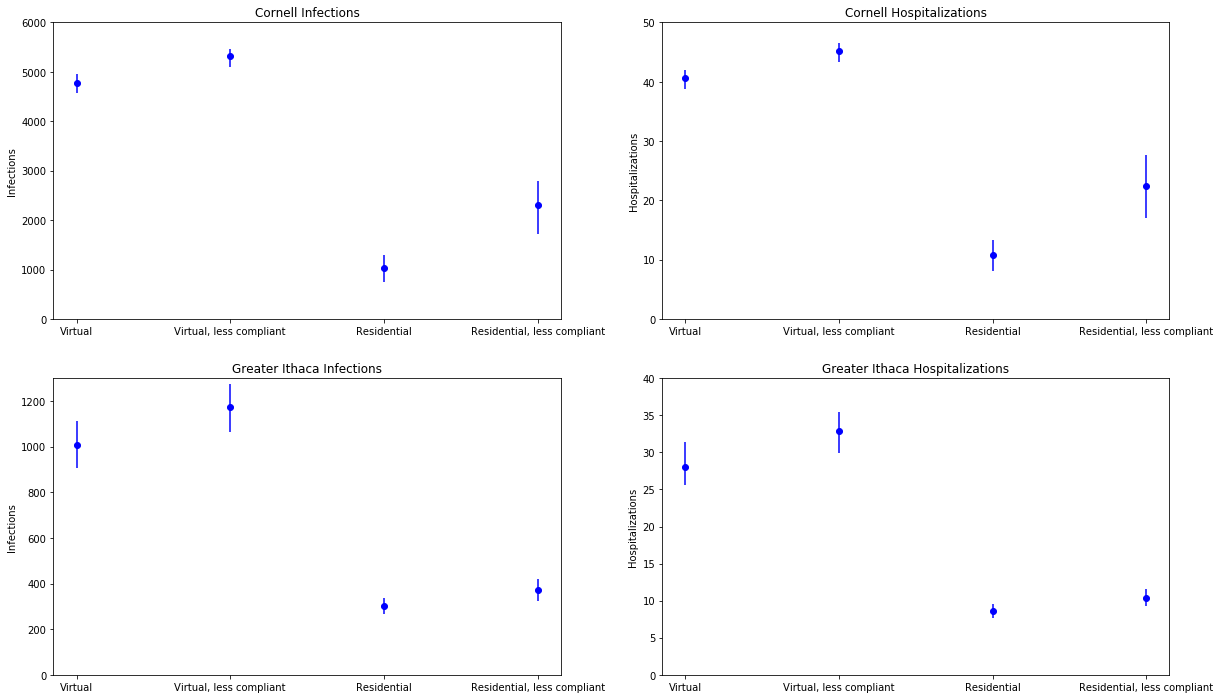

In [112]:
# fig = plt.figure(figsize=(20,12))
# ax = fig.add_subplot(111)

f, axs = plt.subplots(2,2,sharex=True,figsize=(20,12))

plt.subplot(2, 2, 1)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_virtual_normal['cornell_inf_yerr_low'],plotting_data_virtual_normal['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_virtual_less_compliant['cornell_inf_yerr_low'],plotting_data_virtual_less_compliant['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_inperson_normal['cornell_inf_yerr_low'],plotting_data_inperson_normal['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_inperson_less_compliant['cornell_inf_yerr_low'],plotting_data_inperson_less_compliant['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Cornell Infections')
plt.ylabel('Infections')
# plt.xlabel('Scenarios')
plt.ylim(0, 6000)
# plt.show()


# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 2, 2)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_virtual_normal['cornell_hosp_yerr_low'],plotting_data_virtual_normal['cornell_hosp_yerr_high']], fmt='o', color='b', data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_virtual_less_compliant['cornell_hosp_yerr_low'],plotting_data_virtual_less_compliant['cornell_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_inperson_normal['cornell_hosp_yerr_low'],plotting_data_inperson_normal['cornell_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_inperson_less_compliant['cornell_hosp_yerr_low'],plotting_data_inperson_less_compliant['cornell_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
# plt.xlabel('Scenarios')
plt.ylim(0, 50)
# plt.show()



# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 2, 3)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_virtual_normal['ithaca_inf_yerr_low'],plotting_data_virtual_normal['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_virtual_less_compliant['ithaca_inf_yerr_low'],plotting_data_virtual_less_compliant['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_inperson_normal['ithaca_inf_yerr_low'],plotting_data_inperson_normal['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_inperson_less_compliant['ithaca_inf_yerr_low'],plotting_data_inperson_less_compliant['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Greater Ithaca Infections')
plt.ylabel('Infections')
# plt.xlabel('Scenarios')
plt.ylim(0, 1300)
# plt.show()


# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 2, 4)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_virtual_normal['ithaca_hosp_yerr_low'],plotting_data_virtual_normal['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_virtual_less_compliant['ithaca_hosp_yerr_low'],plotting_data_virtual_less_compliant['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_inperson_normal['ithaca_hosp_yerr_low'],plotting_data_inperson_normal['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_inperson_less_compliant['ithaca_hosp_yerr_low'],plotting_data_inperson_less_compliant['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Greater Ithaca Hospitalizations')
plt.ylabel('Hospitalizations')
# plt.xlabel('Scenarios')
plt.ylim(0, 40)
# plt.show()

plt.savefig('res_inst_paper_graphs/virtual_residential_comp.png', dpi=450)

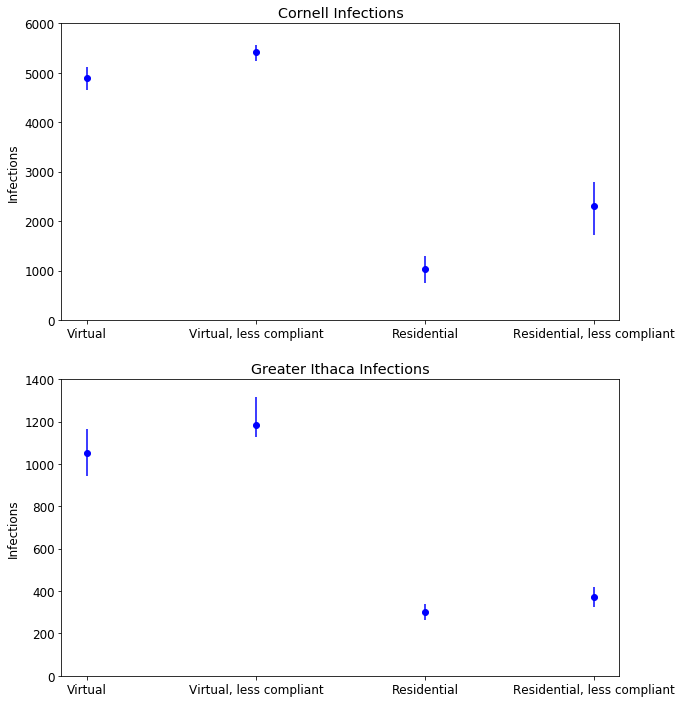

In [23]:
file = open('res_inst_paper_graphs/mar_19_fig_2_data.dill', mode='wb')
dill.dump([plotting_data_virtual_normal, plotting_data_virtual_less_compliant, plotting_data_inperson_normal, plotting_data_inperson_less_compliant], file)
file.close()

# fig = plt.figure(figsize=(20,12))
# ax = fig.add_subplot(111)

f, axs = plt.subplots(2,1,sharex=True,figsize=(10,12))

plt.subplot(2, 1, 1)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_virtual_normal['cornell_inf_yerr_low'],plotting_data_virtual_normal['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_virtual_less_compliant['cornell_inf_yerr_low'],plotting_data_virtual_less_compliant['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_inperson_normal['cornell_inf_yerr_low'],plotting_data_inperson_normal['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_inperson_less_compliant['cornell_inf_yerr_low'],plotting_data_inperson_less_compliant['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Cornell Infections')
plt.ylabel('Infections')
# plt.xlabel('Scenarios')
plt.ylim(0, 6000)
# plt.show()



# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 1, 2)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_virtual_normal['ithaca_inf_yerr_low'],plotting_data_virtual_normal['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_virtual_less_compliant['ithaca_inf_yerr_low'],plotting_data_virtual_less_compliant['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_inperson_normal['ithaca_inf_yerr_low'],plotting_data_inperson_normal['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_inperson_less_compliant['ithaca_inf_yerr_low'],plotting_data_inperson_less_compliant['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Greater Ithaca Infections')
plt.ylabel('Infections')
# plt.xlabel('Scenarios')
plt.ylim(0, 1400)
# plt.show()

# plt.savefig('res_inst_paper_graphs/virtual_residential_comp.png', dpi=450)
plt.savefig('res_inst_paper_graphs/mar_19_graphs/four_scenarios_inf_hosp.png', dpi=450)

# Figure 3 - Contour Plot (# students, daily test frequency), for virtual instruction

In [24]:
np.random.seed(2023)

In [25]:
base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/virtual_instruction/'

gs_research_params = load_params(base_directory + 'grad_research_virtual.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age_virtual.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age_virtual.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age_virtual.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community_virtual.yaml')[1]

ug_off_campus_unmonitored_params = load_params(base_directory + 'ug_off_campus_unmonitored_virtual.yaml')[1]
ug_off_campus_compliant_params = load_params(base_directory + 'ug_off_campus_compliant_virtual.yaml')[1]
gs_other_unmonitored_params = load_params(base_directory + 'grad_other_unmonitored_virtual.yaml')[1]
gs_other_compliant_params = load_params(base_directory + 'grad_other_compliant_virtual.yaml')[1]

In [26]:
# 1/5 students are monitored. Adjust param files manually
total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
ug_off_campus_unmonitored_params['population_size'] = np.ceil(0.8 * total_ug_pop)
ug_off_campus_compliant_params['population_size'] = np.floor(0.2 * total_ug_pop)

In [27]:
def rescale_virtual_interaction_matrix(perc_ug_compliant, group_sizes):
    interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                    [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                    [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                    [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                                   ])
    interaction_matrix[0,0] = (8.8651 + 2.2163) * (1 - perc_ug_compliant)
    interaction_matrix[0,1] = (8.8651 + 2.2163) * (perc_ug_compliant)
    interaction_matrix[1,1] = (8.8651 + 2.2163) * (perc_ug_compliant)
    for i in range(interaction_matrix.shape[0]):
        for j in range(i):
            if ((i,j) == (0,0)) or ((i,j)==(0,1)) or ((i,j)==(1,1)):
                continue
            interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]
    return interaction_matrix

In [28]:
virtual_group_sizes = [ug_off_campus_unmonitored_params['population_size'], ug_off_campus_compliant_params['population_size'], gs_research_params['population_size'], gs_other_unmonitored_params['population_size'], gs_other_compliant_params['population_size'], faculty_staff_student_params['population_size'], faculty_staff_non_student_params['population_size'], faculty_staff_off_campus_params['population_size'], ithaca_community_params['population_size']]
virtual_group_sizes

[5549.0, 1387.0, 1594, 1434, 1434, 3598, 1907, 4778, 62000]

In [29]:
# X_popsize = [3000, 4000, 5000, 6000, 7000, 8000, 9000]
# Y_compliant = [0.01, 0.1, 0.2, 0.3, 0.4]

X_popsize = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
Y_compliant = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

Zs_hosp = []
Zs_inf = []
Zs_cornell_hosp = []
Zs_cornell_inf = []
Zs_UG_hosp = []
Zs_UG_inf = []

for popsize in X_popsize:
    
    Z_hosp = []
    Z_inf = []
    Z_cornell_hosp = []
    Z_cornell_inf = []
    Z_UG_hosp = []
    Z_UG_inf = []
    for perc_compliant in Y_compliant:
#for (contacts, popsize), dfs in sensitivity_output.sim_results['Nominal Student Parameters'].items():
        testing_policy = [0, 2/7,1/7,0,1/7, 2/7,1/7,1/30, 0]

        params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]

        group_names = ['UG unmonitored', 'UG compliant', 'GS research', 'GS compliant', 'GS monitored', 'F/S student', 'F/S non-student', 'F/S off', 'Ithaca']
        
        group_sizes = virtual_group_sizes.copy()
        group_sizes[0] = int(np.ceil(popsize * (1 - perc_compliant)))
        group_sizes[1] = int(np.floor(popsize * perc_compliant))
        
        params_list[0]['population_size'] = group_sizes[0]
        params_list[1]['population_size'] = group_sizes[1]

        # rescale interaction matrix based on population sizes
        interaction_matrix = rescale_virtual_interaction_matrix(perc_compliant, group_sizes)
        
        virtual_normal = list()
        
        print('Evaluating this: ', popsize, perc_compliant)
        tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)

        virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})        
        
        Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
        Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
        Z_cornell_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
        Z_cornell_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))
        Z_UG_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:2],axis=1), 0.5))
        Z_UG_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:2],axis=1), 0.5))        

    Zs_hosp.append(Z_hosp)
    Zs_inf.append(Z_inf)
    Zs_cornell_hosp.append(Z_cornell_hosp)
    Zs_cornell_inf.append(Z_cornell_inf)
    Zs_UG_hosp.append(Z_UG_hosp)
    Zs_UG_inf.append(Z_UG_inf)

Evaluating this:  2000 0.01
Evaluating this:  2000 0.1
Evaluating this:  2000 0.2
Evaluating this:  2000 0.3
Evaluating this:  2000 0.4
Evaluating this:  2000 0.5
Evaluating this:  2000 0.6
Evaluating this:  2000 0.7
Evaluating this:  2000 0.8
Evaluating this:  2000 0.9
Evaluating this:  2000 0.99
Evaluating this:  3000 0.01
Evaluating this:  3000 0.1
Evaluating this:  3000 0.2
Evaluating this:  3000 0.3
Evaluating this:  3000 0.4
Evaluating this:  3000 0.5
Evaluating this:  3000 0.6
Evaluating this:  3000 0.7
Evaluating this:  3000 0.8
Evaluating this:  3000 0.9
Evaluating this:  3000 0.99
Evaluating this:  4000 0.01
Evaluating this:  4000 0.1
Evaluating this:  4000 0.2
Evaluating this:  4000 0.3
Evaluating this:  4000 0.4
Evaluating this:  4000 0.5
Evaluating this:  4000 0.6
Evaluating this:  4000 0.7
Evaluating this:  4000 0.8
Evaluating this:  4000 0.9
Evaluating this:  4000 0.99
Evaluating this:  5000 0.01
Evaluating this:  5000 0.1
Evaluating this:  5000 0.2
Evaluating this:  500

In [30]:
# file = open('res_inst_paper_graphs/fig_3_data.dill', mode='wb')
file = open('res_inst_paper_graphs/mar_19_fig_3_data_v2.dill', mode='wb')
dill.dump([Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, Zs_UG_hosp, Zs_UG_inf, X_popsize, Y_compliant], file)
file.close()

In [47]:
# file = open('res_inst_paper_graphs/fig_3_data.dill', mode='rb')
file = open('res_inst_paper_graphs/mar_19_fig_3_data_v2.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, Zs_UG_hosp, Zs_UG_inf, X_popsize, Y_compliant] = dill.load(file)
file.close()

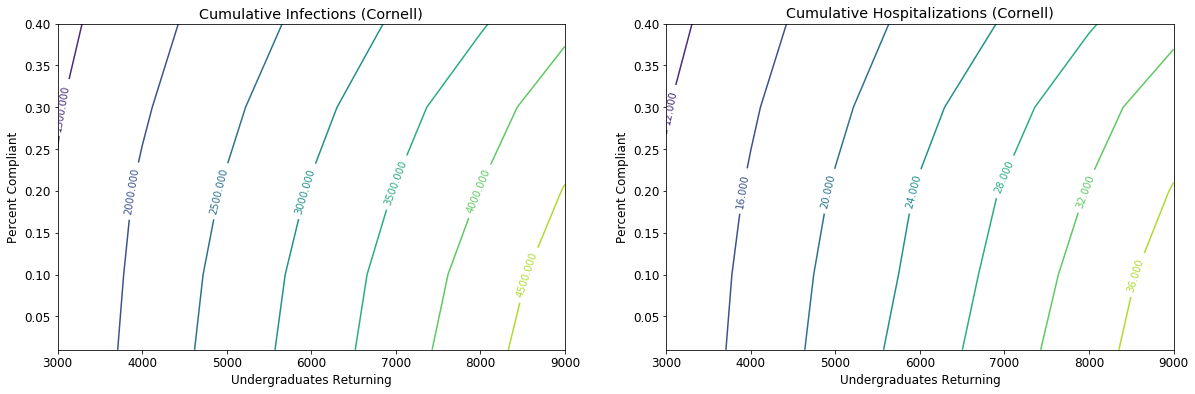

In [43]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,2,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant), np.array(Zs_UG_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)


plt.subplot(1,2,2)
plt.title("Cumulative Hospitalizations (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant), np.array(Zs_UG_hosp).T)
# pop_levels = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]
# pop_labels = dict()
# for level in pop_levels:
#     pop_labels[level] = str(level*100) + '%'
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_hosp).T/34310, pop_levels)
# plt.clabel(CS, fmt=pop_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()


# plt.savefig('res_inst_paper_graphs/test_freq_tr_mult_contour.jpg', dpi=450)

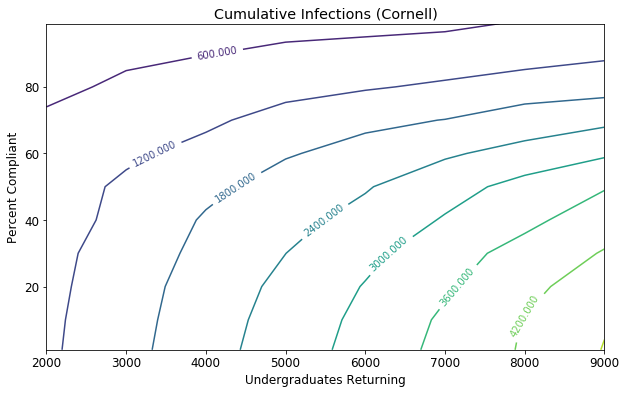

In [32]:
# file = open('res_inst_paper_graphs/fig_3_data.dill', mode='rb')
file = open('res_inst_paper_graphs/mar_19_fig_3_data_v2.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, Zs_UG_hosp, Zs_UG_inf, X_popsize, Y_compliant] = dill.load(file)
file.close()

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,1,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), 100*np.array(Y_compliant), np.array(Zs_UG_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
# plt.show()

plt.savefig('res_inst_paper_graphs/mar_19_graphs/virtual_instr_contour.jpg', dpi=450)

In [33]:
Zs_cornell_inf

[[1844.0,
  1830.5,
  1777.5,
  1718.5,
  1635.5,
  1550.0,
  1461.5,
  1241.0,
  1074.0,
  863.5,
  791.0],
 [2465.0,
  2486.0,
  2316.0,
  2284.5,
  2026.0,
  2001.5,
  1770.0,
  1589.5,
  1252.5,
  1079.0,
  844.5],
 [3128.5,
  3069.0,
  2989.5,
  2788.5,
  2618.5,
  2415.5,
  2070.5,
  1749.5,
  1476.0,
  1096.5,
  908.0],
 [3715.0,
  3722.5,
  3568.5,
  3373.5,
  3167.0,
  2784.5,
  2537.0,
  2117.0,
  1657.0,
  1247.0,
  1059.0],
 [4336.0,
  4247.0,
  4113.5,
  3880.5,
  3529.0,
  3222.0,
  2771.5,
  2413.5,
  1785.5,
  1322.0,
  1068.0],
 [4971.5,
  4860.0,
  4653.5,
  4435.0,
  4016.0,
  3657.5,
  3077.0,
  2610.5,
  1911.0,
  1438.5,
  1102.0],
 [5509.5,
  5495.0,
  5216.5,
  4958.0,
  4523.5,
  4152.5,
  3447.0,
  2824.5,
  2189.5,
  1574.0,
  1294.5],
 [6178.5,
  6061.5,
  5828.5,
  5453.0,
  4974.5,
  4482.0,
  3850.0,
  3059.0,
  2255.5,
  1662.5,
  1186.0]]

# Figure 3 v2 (modeling non-compliance as a reduction in daily test frequency)

# Figure 4 - Sensitivity Analysis (initial prevalence, transmission rate mult, cases found per contact tracing)

In [44]:
np.random.seed(2024)
# params_list, interaction_matrix, group_names = get_nominal_params()

### Initial Prevalence

In [45]:
initial_prevalence_mult_list = [0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4]

nominal_results = list()
optimistic_results = list()
pessimistic_results = list()

testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

for initial_prevalence_mult in initial_prevalence_mult_list:
    print('Evaluating this mult: ', initial_prevalence_mult)
    nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
    optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
    pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
    for param_config in nominal_params_list:
        param_config['initial_ID_prevalence'] *= initial_prevalence_mult
    for param_config in optimistic_params_list:
        param_config['initial_ID_prevalence'] *= initial_prevalence_mult
    for param_config in pessimistic_params_list:
        param_config['initial_ID_prevalence'] *= initial_prevalence_mult

#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
    nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
    optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
    pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})


Evaluating this mult:  0.5
Evaluating this mult:  0.75
Evaluating this mult:  1
Evaluating this mult:  1.5
Evaluating this mult:  2
Evaluating this mult:  2.5
Evaluating this mult:  3
Evaluating this mult:  3.5
Evaluating this mult:  4


In [46]:
plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
plotting_data_nominal_results['initial_prev_mult'] = initial_prevalence_mult_list
plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
plotting_data_optimistic_results['initial_prev_mult'] = initial_prevalence_mult_list
plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
plotting_data_pessimistic_results['initial_prev_mult'] = initial_prevalence_mult_list


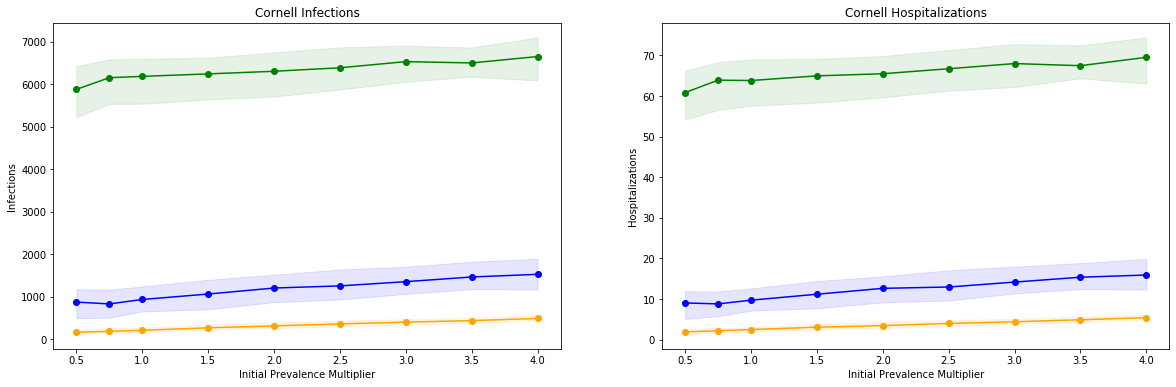

In [115]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)

plt.subplot(1,2,2)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)
# plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_prevalence.jpg', dpi=450)

### Transmission Rate Mult 

In [48]:
TR_mult_list = [0.5, 0.75, 1, 1.5, 2, 2.5, 3]

TR_nominal_results = list()
TR_optimistic_results = list()
TR_pessimistic_results = list()

testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

for TR_mult in TR_mult_list:
    print('Evaluating this mult: ', TR_mult)
    nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
    optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
    pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
    
    nominal_interaction_matrix *= TR_mult
    optimistic_interaction_matrix *= TR_mult
    pessimistic_interaction_matrix *= TR_mult

#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
    TR_nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
    optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    TR_optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
    pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    TR_pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})


Evaluating this mult:  0.5


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Evaluating this mult:  0.75
Evaluating this mult:  1
Evaluating this mult:  1.5
Evaluating this mult:  2
Evaluating this mult:  2.5
Evaluating this mult:  3


In [49]:
plotting_data_TR_nominal_results = generate_plotting_matrix(TR_nominal_results)
plotting_data_TR_nominal_results['TR_mult'] = TR_mult_list
plotting_data_TR_optimistic_results = generate_plotting_matrix(TR_optimistic_results)
plotting_data_TR_optimistic_results['TR_mult'] = TR_mult_list
plotting_data_TR_pessimistic_results = generate_plotting_matrix(TR_pessimistic_results)
plotting_data_TR_pessimistic_results['TR_mult'] = TR_mult_list


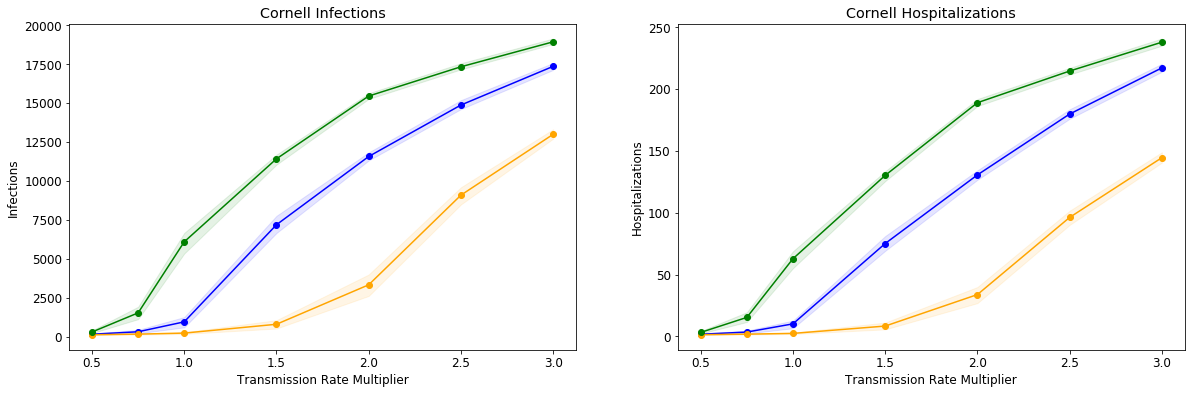

<Figure size 432x288 with 0 Axes>

In [50]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)

plt.subplot(1,2,2)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_transmission_rate.jpg', dpi=450)

### Cases found per contact trace

In [35]:
nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
nominal_params_list[0].keys()

dict_keys(['severity_prevalence', 'population_size', 'initial_ID_prevalence', 'max_time_ID', 'ID_time_function', 'max_time_SyID_mild', 'SyID_mild_time_function', 'max_time_SyID_severe', 'SyID_severe_time_function', 'max_time_exposed', 'exposed_time_function', 'exposed_infection_p', 'expected_contacts_per_day', 'daily_outside_infection_p', 'mild_symptoms_daily_self_report_p', 'severe_symptoms_daily_self_report_p', 'sample_QI_exit_function', 'sample_QS_exit_function', 'perform_contact_tracing', 'contact_tracing_delay', 'cases_isolated_per_contact', 'cases_quarantined_per_contact', 'use_asymptomatic_testing', 'contact_trace_testing_frac', 'days_between_tests', 'test_population_fraction', 'test_protocol_QFNR', 'test_protocol_QFPR', 'max_time_pre_ID', 'pre_ID_time_function', 'initial_E_count', 'initial_pre_ID_count', 'initial_ID_count', 'initial_SyID_mild_count', 'initial_SyID_severe_count', 'pre_ID_state', 'mild_severity_levels'])

In [51]:
CI_mult_list = [0.5, 0.75, 1, 1.5, 2, 2.5]

CI_nominal_results = list()
CI_optimistic_results = list()
CI_pessimistic_results = list()

testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

for CI_mult in CI_mult_list:
    print('Evaluating this mult: ', CI_mult)
    nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
    optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
    pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
    for param_config in nominal_params_list:
        param_config['cases_isolated_per_contact'] *= CI_mult
    for param_config in optimistic_params_list:
        param_config['cases_isolated_per_contact'] *= CI_mult
    for param_config in pessimistic_params_list:
        param_config['cases_isolated_per_contact'] *= CI_mult

#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
    CI_nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
    optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    CI_optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
    pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    CI_pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})


Evaluating this mult:  0.5


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Evaluating this mult:  0.75
Evaluating this mult:  1
Evaluating this mult:  1.5
Evaluating this mult:  2
Evaluating this mult:  2.5


In [52]:
plotting_data_CI_nominal_results = generate_plotting_matrix(CI_nominal_results)
plotting_data_CI_nominal_results['CI_mult'] = CI_mult_list
plotting_data_CI_optimistic_results = generate_plotting_matrix(CI_optimistic_results)
plotting_data_CI_optimistic_results['CI_mult'] = CI_mult_list
plotting_data_CI_pessimistic_results = generate_plotting_matrix(CI_pessimistic_results)
plotting_data_CI_pessimistic_results['CI_mult'] = CI_mult_list


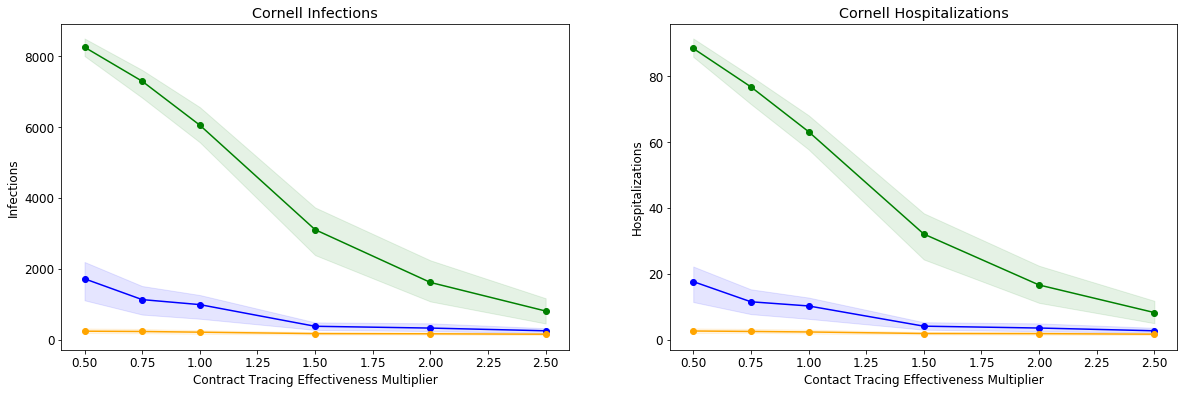

<Figure size 432x288 with 0 Axes>

In [53]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Contract Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)

plt.subplot(1,2,2)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Contact Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_contact_tracing_effectiveness.jpg', dpi=450)

In [54]:
file = open('res_inst_paper_graphs/mar_19_fig_4_data.dill', mode='wb')
dill.dump([[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results],
          [plotting_data_TR_nominal_results, plotting_data_TR_optimistic_results, plotting_data_pessimistic_results],
          [plotting_data_CI_nominal_results, plotting_data_CI_optimistic_results, plotting_data_CI_pessimistic_results]], file)
file.close()

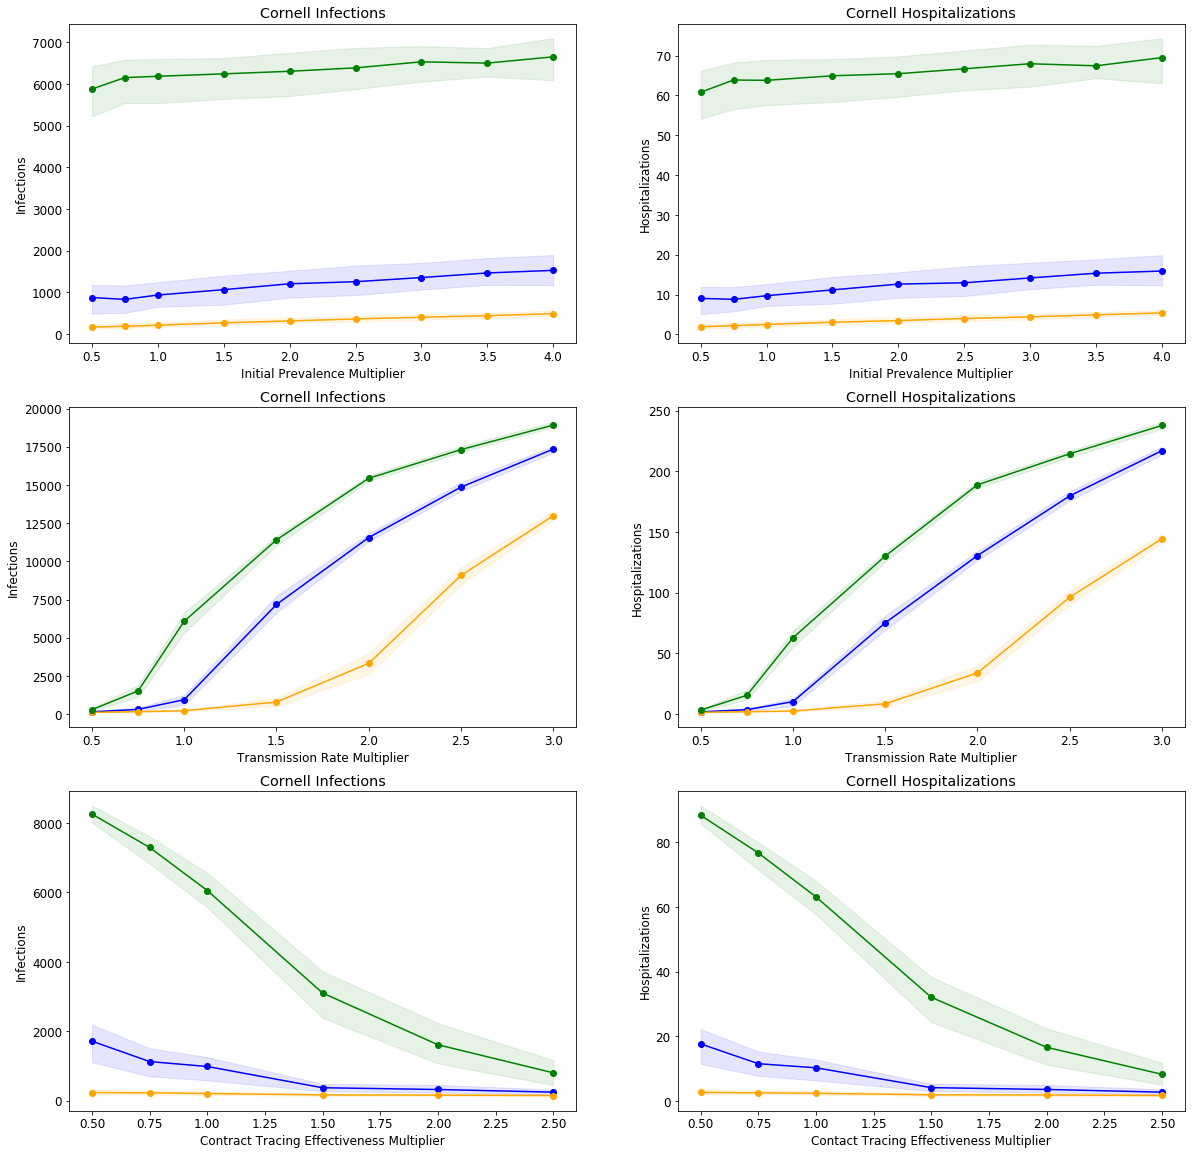

<Figure size 432x288 with 0 Axes>

In [55]:
f, axs = plt.subplots(3,2,sharex=False,figsize=(20,20))

plt.subplot(3, 2, 1)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3,2,2)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3, 2, 3)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3,2,4)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3, 2, 5)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Contract Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3,2,6)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Contact Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_combined.png', dpi=450)

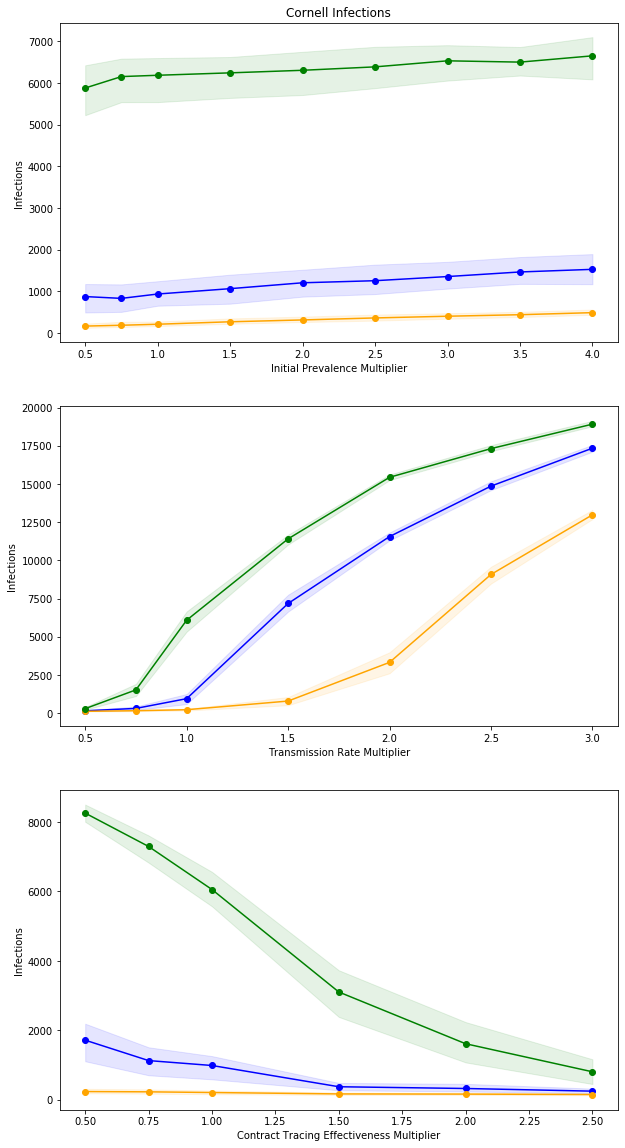

In [116]:
file = open('res_inst_paper_graphs/mar_19_fig_4_data.dill', mode='rb')
[[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results],
          [plotting_data_TR_nominal_results, plotting_data_TR_optimistic_results, plotting_data_pessimistic_results],
          [plotting_data_CI_nominal_results, plotting_data_CI_optimistic_results, plotting_data_CI_pessimistic_results]] = dill.load(file)
file.close()

f, axs = plt.subplots(3,1,sharex=False,figsize=(10,20))

plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3, 1, 2)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
# plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)


plt.subplot(3, 1, 3)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
# plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Contract Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

# plt.show()

plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_initial_prev_TR_CT.png', dpi=450)

# Figure 5 - Infections vs. Daily tests (pareto-efficient frontier)

In [34]:
def plot_policy_performance(plotting_data, selected_policy_index):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Infections vs. Daily tests for various policies')
    plt.ylabel('Infections')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Hospitalizations vs. Daily tests for various policies')
    plt.ylabel('Hospitalizations')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data['cornell_inf_yerr_low'],plotting_data['cornell_inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Cornell Infections vs. Daily tests for various policies')
    plt.ylabel('Cornell Infections')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data['cornell_hosp_yerr_low'],plotting_data['cornell_hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
    plt.ylabel('Cornell Hospitalizations')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

In [35]:
np.random.seed(2025)
params_list, interaction_matrix, group_names = get_nominal_params()

In [36]:
limited_policies = [[1/7,1/7,1/7,1/7,1/7,1/7,1/14,0],
[2/7,1/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,2/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,1/7,2/7,1/30,0],
# [2/7,2/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,2/7,2/7,1/7,2/7,1/7,1/30,0],
[2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]]

In [37]:
results_baseline = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 100)
    results_baseline.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285,

In [38]:
plotting_data = generate_plotting_matrix(results_baseline)

In [39]:
file = open('res_inst_paper_graphs/mar_19_fig_5_data.dill', mode='wb')
dill.dump([plotting_data], file)
file.close()

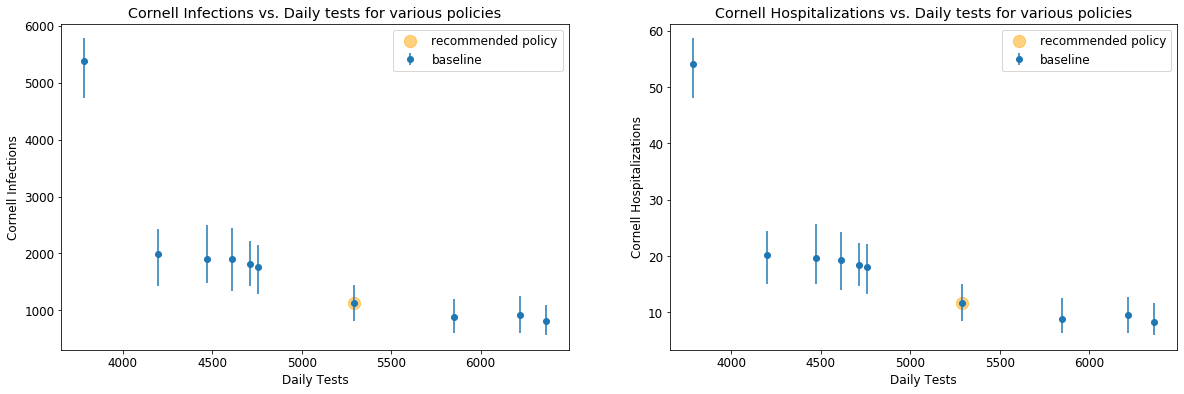

<Figure size 432x288 with 0 Axes>

In [62]:
selected_policy_index = 3

f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

# plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
# plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# # for index in range(len(text_x)):
# #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
# plt.title('Infections vs. Daily tests for various policies')
# plt.ylabel('Infections')
# plt.xlabel('Daily Tests')
# plt.legend()

# plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
# plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# # for index in range(len(text_x)):
# #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
# plt.title('Hospitalizations vs. Daily tests for various policies')
# plt.ylabel('Hospitalizations')
# plt.xlabel('Daily Tests')
# plt.legend()
# plt.show()

plt.subplot(1,2,1)
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data['cornell_inf_yerr_low'],plotting_data['cornell_inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()


plt.subplot(1,2,2)
plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data['cornell_hosp_yerr_low'],plotting_data['cornell_hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

plt.savefig('res_inst_paper_graphs/testing_policy.png', dpi=450)

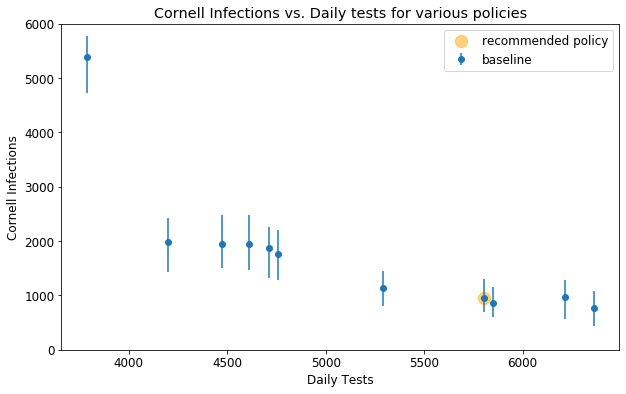

In [43]:
file = open('res_inst_paper_graphs/mar_19_fig_5_data.dill', mode='rb')
[plotting_data] = dill.load(file)
file.close()

selected_policy_index = 3

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

plt.subplot(1,1,1)
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data['cornell_inf_yerr_low'],plotting_data['cornell_inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()
plt.ylim([0,6000])

# plt.show()

plt.savefig('res_inst_paper_graphs/mar_19_graphs/testing_policies_pareto.png', dpi=450)

In [41]:
plotting_data

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,hosp_yerr_low,hosp_yerr_high,cornell_inf_yerr_low,cornell_inf_yerr_high,cornell_hosp_yerr_low,cornell_hosp_yerr_high,ithaca_inf_yerr_low,ithaca_inf_yerr_high,ithaca_hosp_yerr_low,ithaca_hosp_yerr_high
0,3785.857143,6013.0,5310.3,6521.3,71.978901,63.155001,78.192887,5388.5,4729.3,5777.4,...,8.823900,6.213985,659.2,388.9,6.111543,4.515096,82.5,76.8,2.475871,2.092458
1,4199.123810,2370.5,1774.6,2849.3,30.899667,23.871560,35.792143,1988.0,1428.8,2424.9,...,7.028107,4.892476,559.2,436.9,5.164647,4.238844,53.0,55.2,1.431682,1.757991
2,5290.123810,1443.0,1091.1,1835.3,20.709317,16.859481,25.264268,1129.5,814.5,1453.5,...,3.849837,4.554950,315.0,324.0,3.044105,3.498563,45.2,54.2,1.264448,1.549969
3,5804.123810,1273.5,961.6,1641.6,18.585196,15.064843,22.747773,954.0,687.8,1303.0,...,3.520352,4.162578,266.2,349.0,2.709750,3.553459,27.1,43.6,0.844325,1.207344
4,4612.695238,2320.5,1804.0,2870.4,30.397688,24.761185,36.730993,1948.0,1459.8,2472.7,...,5.636503,6.333305,488.2,524.7,4.711199,4.902730,50.6,55.6,1.549969,1.456155
5,4757.409524,2141.0,1623.7,2608.8,28.134503,22.233100,34.002082,1770.5,1283.0,2204.5,...,5.901403,5.867579,487.5,434.0,4.875178,4.337366,55.2,53.4,1.537732,1.501022
6,4713.123810,2243.0,1683.4,2620.2,29.545546,21.984115,33.780223,1871.5,1324.4,2267.0,...,7.561431,4.234677,547.1,395.5,5.323220,4.068355,52.7,46.6,1.252212,1.366420
7,4471.552381,2330.5,1835.4,2926.1,30.095106,24.579115,36.947497,1949.0,1509.5,2472.5,...,5.515991,6.852391,439.5,523.5,4.439126,5.249835,54.1,57.5,1.329710,1.570363
8,5848.409524,1163.0,905.7,1534.5,17.744287,14.788631,22.163655,863.0,602.7,1164.0,...,2.955656,4.419368,260.3,301.0,2.347125,2.984199,30.6,46.8,0.978928,1.203265
9,6217.695238,1269.0,857.2,1583.7,18.612532,14.175457,22.126428,967.5,564.5,1281.5,...,4.437075,3.513897,403.0,314.0,3.749939,3.140208,32.8,47.5,0.938139,1.064584


# Figure 6 - Contour plot (mult of transmission rate, daily test %) split by inf, hosp

In [63]:
X_TR = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5]
Y_test_freq = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]

Zs_hosp = list()
Zs_inf = list()
Zs_cornell_hosp = list()
Zs_cornell_inf = list()
for TR in X_TR:
    
    Z_hosp = list()
    Z_inf = list()
    Z_cornell_hosp = list()
    Z_cornell_inf = list()
    for test_freq in Y_test_freq:
        params_list, interaction_matrix, group_names = get_nominal_params()
#for (contacts, popsize), dfs in sensitivity_output.sim_results['Nominal Student Parameters'].items():
        testing_policy = np.array([2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]) * test_freq
        interaction_matrix *= TR
#         virtual_normal = list()
        
        print('Evaluating this: ', TR, test_freq)
        tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 25)
#         virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})
        
        Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
        Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
        Z_cornell_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
        Z_cornell_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))

    Zs_hosp.append(Z_hosp)
    Zs_inf.append(Z_inf)
    Zs_cornell_hosp.append(Z_cornell_hosp)
    Zs_cornell_inf.append(Z_cornell_inf)

Evaluating this:  0.5 0.5
Evaluating this:  0.5 0.75
Evaluating this:  0.5 1
Evaluating this:  0.5 1.25
Evaluating this:  0.5 1.5
Evaluating this:  0.5 1.75
Evaluating this:  0.5 2
Evaluating this:  0.5 2.25
Evaluating this:  0.5 2.5
Evaluating this:  0.75 0.5
Evaluating this:  0.75 0.75
Evaluating this:  0.75 1
Evaluating this:  0.75 1.25
Evaluating this:  0.75 1.5
Evaluating this:  0.75 1.75
Evaluating this:  0.75 2
Evaluating this:  0.75 2.25
Evaluating this:  0.75 2.5
Evaluating this:  1 0.5
Evaluating this:  1 0.75
Evaluating this:  1 1
Evaluating this:  1 1.25
Evaluating this:  1 1.5
Evaluating this:  1 1.75
Evaluating this:  1 2
Evaluating this:  1 2.25
Evaluating this:  1 2.5
Evaluating this:  1.25 0.5
Evaluating this:  1.25 0.75
Evaluating this:  1.25 1
Evaluating this:  1.25 1.25
Evaluating this:  1.25 1.5
Evaluating this:  1.25 1.75
Evaluating this:  1.25 2
Evaluating this:  1.25 2.25
Evaluating this:  1.25 2.5
Evaluating this:  1.5 0.5
Evaluating this:  1.5 0.75
Evaluating 

In [64]:
# file = open('res_inst_paper_graphs/fig_6_data.dill', mode='wb')
file = open('res_inst_paper_graphs/mar_19_fig_6_data.dill', mode='wb')
dill.dump([Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X_TR, Y_test_freq], file)
file.close()

In [50]:
# file = open('res_inst_paper_graphs/fig_6_data.dill', mode='rb')
file = open('res_inst_paper_graphs/mar_19_fig_6_data.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X_TR, Y_test_freq] = dill.load(file)
file.close()

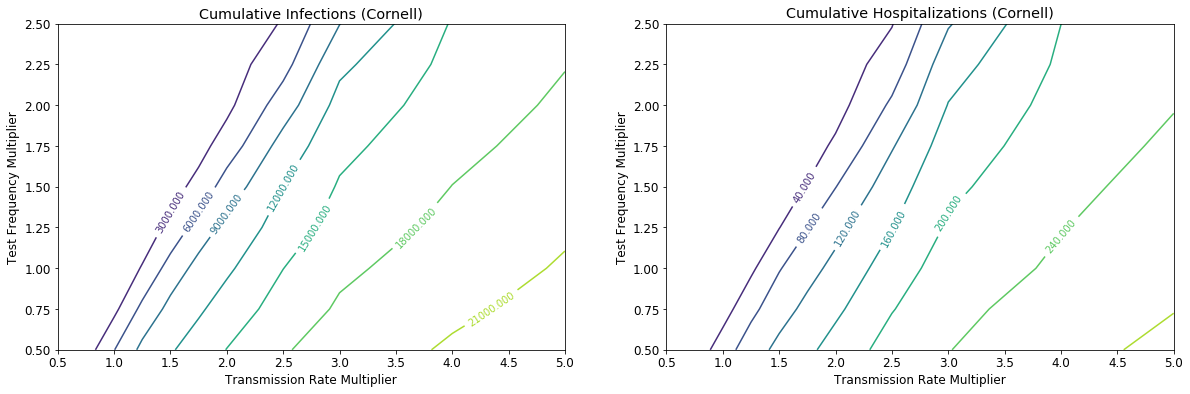

In [65]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))


# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,2,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Test Frequency Multiplier")
plt.xlabel("Transmission Rate Multiplier")
CS = plt.contour(np.array(X_TR), np.array(Y_test_freq), np.array(Zs_cornell_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
# plt.ylim(0.5, 2.5)


plt.subplot(1,2,2)
plt.title("Cumulative Hospitalizations (Cornell)")
plt.ylabel("Test Frequency Multiplier")
plt.xlabel("Transmission Rate Multiplier")
CS = plt.contour(np.array(X_TR), np.array(Y_test_freq), np.array(Zs_cornell_hosp).T)
# pop_levels = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]
# pop_labels = dict()
# for level in pop_levels:
#     pop_labels[level] = str(level*100) + '%'
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_hosp).T/34310, pop_levels)
# plt.clabel(CS, fmt=pop_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
# plt.ylim(0.5, 2.5)
plt.show()


# plt.savefig('res_inst_paper_graphs/test_freq_tr_mult_contour.png', dpi=450)

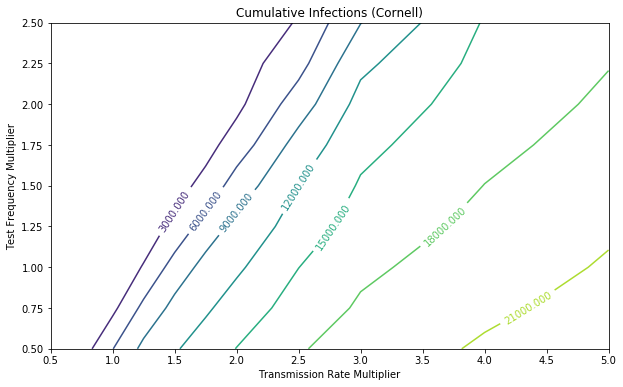

In [118]:
file = open('res_inst_paper_graphs/mar_19_fig_6_data.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X_TR, Y_test_freq] = dill.load(file)
file.close()

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

plt.subplot(1,1,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Test Frequency Multiplier")
plt.xlabel("Transmission Rate Multiplier")
CS = plt.contour(np.array(X_TR), np.array(Y_test_freq), np.array(Zs_cornell_inf).T)
plt.clabel(CS, inline=1, fontsize=10)

# plt.show()

plt.savefig('res_inst_paper_graphs/mar_19_graphs/contour_TR_compliance_test_freq.png', dpi=450)

# Figure 7 - Shutdown policies

In [66]:
lockdown_matrix_str = \
"""6.25	2	0.05	0.05	0	0	0	0.02
1.70	4	0.05	0.05	0	0	0	0.04
0.09	0.11	2	0.05	0	0	0	0.36
0.07	0.08	0.04	4.5	0	0	0	0.04
0.00	0.00	0.00	0.00	0.5	0.075	0.15	0.78
0.00	0.00	0.00	0.00	0.14	0.9	0.1	0.78
0.00	0.00	0.00	0.00	0.11	0.04	0.9	0.78
0.002	0.005	0.021	0.003	0.045	0.024	0.060	3.5"""

lockdown_matrix = np.array([[float(entry) for entry in line.split('\t')] for line in lockdown_matrix_str.split('\n')])

In [67]:
def run_multigroup_sim(sim, T):
    lockdown_statuses, sim_df = sim.run_new_trajectory(12*7)
    popsize = sim.get_total_population()
    infection_counts = sim_df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list, lockdown_statuses, list(infection_counts)

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    lockdown_trajectories = []
    infection_trajectories = []
    for _ in range(n):
        inf, hosp, lockdowns, infections = run_multigroup_sim(sim, T)
        inf_matrix.append(inf)
        hosp_matrix.append(hosp)
        lockdown_trajectories.append(lockdowns)
        infection_trajectories.append(infections)
    return inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories

In [68]:
def get_params_list_copy():
    return get_nominal_params()[0]

In [69]:
params_list, interaction_matrix, group_names = get_nominal_params()
sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
popsize = sim.get_total_population()

In [70]:
def evaluate_testing_policy_v2(params_list, interaction_matrix, group_names, test_frac, T, n,
                           post_lockdown_matrix, new_cases_threshold, new_cases_time_window):
    assert len(params_list) == len(test_frac)
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    sim.configure_lockdown(post_lockdown_matrix, [True] * 7 + [False], new_cases_threshold, new_cases_time_window)
    
    inf_matrix, hosp_matrix, lockdown_trajectories, infection_trajectories = run_multiple_trajectories(sim, T, n)
    
    return lockdown_trajectories, infection_trajectories

In [71]:
import copy

def get_interaction_matrix(contact_multiplier):
    new_interaction_matrix = copy.copy(interaction_matrix)
    ithaca_group_id = 7
    for i in range(interaction_matrix.shape[0]):
        for j in range(interaction_matrix.shape[1]):
            if i != ithaca_group_id and j != ithaca_group_id:
                new_interaction_matrix[i,j] = contact_multiplier * new_interaction_matrix[i,j]
    return new_interaction_matrix

In [72]:
def simulate_lockdown_v2(contact_multiplier, infections_thresh, infections_window, nreps=10):
    simulation_population = 90890
    new_cases_thresh = infections_thresh
#     new_cases_thresh = infections_thresh / simulation_population
    test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    
    return evaluate_testing_policy_v2(get_params_list_copy(),
                                      get_interaction_matrix(contact_multiplier),
                                      group_names,
                                      test_policy,
                                      112,
                                      nreps,
                                      lockdown_matrix,
                                       new_cases_thresh,
                                       infections_window)

In [73]:
import multiprocessing, time

def run_sim_wrapper(contact_multiplier, infections_thresh, infections_window,
                    proc_key, nreps, return_dict):
    lockdowns, final_infections = simulate_lockdown_v2(contact_multiplier, 
                                                    infections_thresh, 
                                                    infections_window,
                                                    nreps=nreps)
    return_dict[proc_key] = {'lockdown_pct': lockdowns,
                            'final_infection_pct': final_infections}


    
def simulate_protocol_multiprocessing(infections_thresh, infections_window, nreps):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    jobs = []


    for mult in [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]:
        p = multiprocessing.Process(target = run_sim_wrapper,
                                   args = (mult, infections_thresh, infections_window, mult, nreps, return_dict))
        jobs.append(p)
        p.start()

    for p in jobs:
        p.join()
    
    return return_dict


In [74]:
nreps = 100
return_dicts = {}
infection_thresholds = [150,200,250,300,350]
infection_windows = [7]

import itertools

for thresh, window in itertools.product(infection_thresholds, infection_windows):
    start = time.time()
    return_dict = simulate_protocol_multiprocessing(thresh, window, nreps)
    end = time.time()
    return_dicts[(thresh, window)] = {key:val for key,val in return_dict.items()}
    print("done simulating {} in {:.2f} seconds".format((thresh, window), end-start))


done simulating (150, 7) in 704.20 seconds
done simulating (200, 7) in 703.66 seconds
done simulating (250, 7) in 705.57 seconds
done simulating (300, 7) in 703.74 seconds
done simulating (350, 7) in 703.35 seconds


#### Figure: Total infections under various policies as transmission rate scales

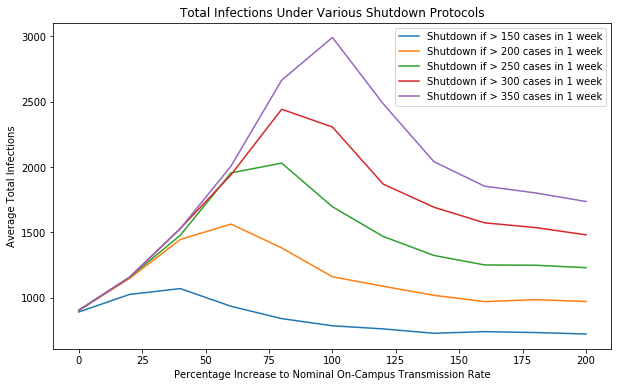

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]

keys = list(return_dicts.keys())

xlabel_mults = [(mult-1)*100 for mult in mults]

for key in keys:
    if key[0] == 400:
        continue
    return_dict = return_dicts[key]
    infections = []
    for mult in mults:
        infections.append(np.mean([inf[-1] / 100 * popsize for inf in return_dict[mult]['final_infection_pct']]))
    plt.plot(xlabel_mults, infections, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Average Total Infections")
plt.title("Total Infections Under Various Shutdown Protocols")
plt.legend(loc='best')

plt.savefig('res_inst_paper_graphs/mar_19_graphs/shutdown_infections.png', dpi=450)

In [76]:
return_dicts[(200,7)][1.2]['final_infection_pct'][0]

[0.10232148751237759,
 0.12102541533722082,
 0.12872703267686214,
 0.14633072945318518,
 0.15513257784134668,
 0.17053581252062933,
 0.18593904719991197,
 0.19694135768511387,
 0.22004620970403785,
 0.23654967543184066,
 0.24865221696556278,
 0.27395753108152715,
 0.29046099680932996,
 0.31026515568269336,
 0.33557046979865773,
 0.35207393552646055,
 0.36307624601166244,
 0.37517878754538453,
 0.3971834085157883,
 0.41918802948619205,
 0.4345912641654747,
 0.447794036747717,
 0.46539773352404007,
 0.48740235449444386,
 0.511607437561888,
 0.5281109032896908,
 0.5457146000660139,
 0.5633182968423369,
 0.587523379909781,
 0.6117284629772253,
 0.6293321597535482,
 0.6447353944328309,
 0.6579381670150731,
 0.6810430190339971,
 0.6997469468588403,
 0.7162504125866432,
 0.732753878314446,
 0.7536582682363296,
 0.7690615029156123,
 0.7789635823522939,
 0.7987677412256575,
 0.8119705138078995,
 0.8328749037297833,
 0.8482781384090659,
 0.8669820662339092,
 0.877984376719111,
 0.895588073495434

#### Figure: Probability of shutdown under various policies as transmission rate scales

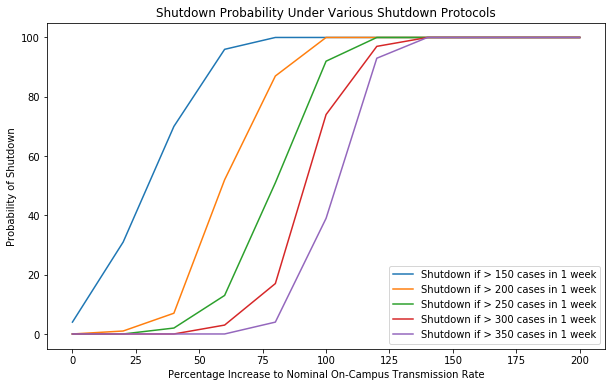

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

mults = [1,1.2,1.4,1.6,1.8,2, 2.2, 2.4, 2.6, 2.8, 3]
for key in keys:
    if key[0] == 400: 
        continue
    return_dict = return_dicts[key]
    lockdowns = []
    for mult in mults:
        lockdowns.append(np.mean([pct[-1] for pct in return_dict[mult]['lockdown_pct']]) * 100)
    plt.plot(xlabel_mults, lockdowns, label="Shutdown if > {} cases in 1 week".format(key[0]))

plt.xlabel("Percentage Increase to Nominal On-Campus Transmission Rate")
plt.ylabel("Probability of Shutdown")
plt.title("Shutdown Probability Under Various Shutdown Protocols")
plt.legend(loc='best')

plt.savefig('res_inst_paper_graphs/mar_19_graphs/shutdown_prob_shutdown.png', dpi=450)

# Contour Plots

In [78]:
from multiprocessing import Process

In [ ]:
# Controls: test frequency multiplier, contact tracing effectiveness multiplier
# Environmental variables: transmission rate multiplier, contact tracing effectiveness, test compliance, initial prevalence, asymptomatic rate, prevalence in external community

In [86]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [87]:
X_TR_mult = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5]
X_test_compliance = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
X_student_initial_prevalence = [0.001, 0.0019, 0.005, 0.0075, 0.01, 0.0125, 0.15, 0.0175, 0.2]

Y_test_freq = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
Y_contact_tracing_effectiveness = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
Y_test_sensitivity = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

In [88]:
def generate_contour_data(X,Y, X_list, Y_list, pickle_file_loc, seed):
    np.random.seed(seed)
    assert X in ['transmission rate', 'test compliance', 'student prevalence']
    assert Y in ['test freq', 'contact tracing', 'test sensitivity']
    
    Zs_hosp = []
    Zs_inf = []
    Zs_cornell_hosp = []
    Zs_cornell_inf = []
#     Zs_UG_hosp = []
#     Zs_UG_inf = []
    
    for X_val in X_list:
        Z_hosp = []
        Z_inf = []
        Z_cornell_hosp = []
        Z_cornell_inf = []
        Z_UG_hosp = []
        Z_UG_inf = []
        
        for Y_val in Y_list:
            params_list, interaction_matrix, group_names = get_nominal_params()
            testing_policy = np.array([2/7,2/7,1/7,1/7,2/7,1/7,1/30,0])
            
            if X == 'transmission rate':
                interaction_matrix *= X_val
            elif X == 'test compliance':
                for params in params_list:
                    params['test_protocol_QFNR'] = 1 - (0.6 * X_val)
            elif X == 'student prevalence':
                params_list[0]['initial_ID_prevalence'] *= X_val
                params_list[1]['initial_ID_prevalence'] *= X_val
                params_list[3]['initial_ID_prevalence'] *= X_val
            
            if Y == 'test freq':
                testing_policy *= Y_val
            elif Y == 'contact tracing':
                for params in params_list:
                    params['cases_isolated_per_contact'] *= Y_val
            elif Y == 'test sensitivity':
                for params in params_list:
                    if X == 'test compliance':
                        params['test_protocol_QFNR'] = 1 - (Y_val * X_val)
                    else:
                        params['test_protocol_QFNR'] = 1 - (Y_val * 0.9)
            
            print('Evaluating this: ', X , X_val, Y, Y_val)
            tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 25)

            Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
            Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
            Z_cornell_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
            Z_cornell_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))

        Zs_hosp.append(Z_hosp)
        Zs_inf.append(Z_inf)
        Zs_cornell_hosp.append(Z_cornell_hosp)
        Zs_cornell_inf.append(Z_cornell_inf)

    file = open(pickle_file_loc, mode='wb')
    dill.dump([Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X, X_list, Y, Y_list], file)
    file.close()
            

In [89]:
def run_new_process(X,Y, X_list, Y_list, pickle_file_loc, seed):
    p = Process(target = generate_contour_data, args = (X,Y, X_list, Y_list, pickle_file_loc, seed))
    p.start()
    return p

In [90]:
# Note: v2 fixes how test compliance is varied (previously multiplied test policy. Now changes params test QFNR)

# Contour: X - Transmission Rate, Y - test freq
p_tr_test_freq = run_new_process('transmission rate', 'test freq', X_TR_mult, Y_test_freq, 'res_inst_paper_graphs/mar_19_contour_tr_test_freq_v2.dill', 2030)

# Contour: X - Test Compliance, Y - test freq
p_test_compliance_test_freq = run_new_process('test compliance', 'test freq', X_test_compliance, Y_test_freq, 'res_inst_paper_graphs/mar_19_contour_test_compliance_test_freq_v2.dill', 2031)

# Contour: X - Student Prevalence, Y - test freq
p_prevalence_test_freq = run_new_process('student prevalence', 'test freq', X_student_initial_prevalence, Y_test_freq, 'res_inst_paper_graphs/mar_19_contour_prevalence_test_freq_v2.dill', 2032)

# Contour: X - Transmission Rate, Y - contact tracing
p_tr_contact_tracing = run_new_process('transmission rate', 'contact tracing', X_TR_mult, Y_contact_tracing_effectiveness, 'res_inst_paper_graphs/mar_19_contour_tr_contact_tracing_v2.dill', 2033)

# Contour: X - Test Compliance, Y - contact tracing
p_test_compliance_contact_tracing = run_new_process('test compliance', 'contact tracing', X_test_compliance, Y_contact_tracing_effectiveness, 'res_inst_paper_graphs/mar_19_contour_test_compliance_contact_tracing_v2.dill', 2034)

# Contour: X - Student Prevalence, Y - contact tracing
p_prevalence_contact_tracing = run_new_process('student prevalence', 'contact tracing', X_student_initial_prevalence, Y_contact_tracing_effectiveness, 'res_inst_paper_graphs/mar_19_contour_prevalence_contact_tracing_v2.dill', 2035)

Evaluating this:  student prevalence 0.001 test freq 0.5
Evaluating this:  test compliance 0.5 contact tracing 0.5
Evaluating this:  test compliance 0.5 test freq 0.5
Evaluating this:  transmission rate 0.5 test freq 0.5
Evaluating this:  transmission rate 0.5 contact tracing 0.5
Evaluating this:  student prevalence 0.001 contact tracing 0.5
Evaluating this:  student prevalence 0.001 contact tracing 0.75
Evaluating this:  test compliance 0.5 contact tracing 0.75
Evaluating this:  transmission rate 0.5 contact tracing 0.75
Evaluating this:  test compliance 0.5 test freq 0.75
Evaluating this:  transmission rate 0.5 test freq 0.75
Evaluating this:  student prevalence 0.001 test freq 0.75
Evaluating this:  student prevalence 0.001 contact tracing 1
Evaluating this:  transmission rate 0.5 contact tracing 1
Evaluating this:  test compliance 0.5 contact tracing 1
Evaluating this:  transmission rate 0.5 test freq 1
Evaluating this:  student prevalence 0.001 test freq 1
Evaluating this:  test c

Evaluating this:  transmission rate 1 test freq 1.75
Evaluating this:  test compliance 0.7 contact tracing 2
Evaluating this:  student prevalence 0.005 contact tracing 2
Evaluating this:  transmission rate 1 contact tracing 2
Evaluating this:  test compliance 0.7 test freq 2
Evaluating this:  student prevalence 0.005 test freq 2
Evaluating this:  transmission rate 1 test freq 2
Evaluating this:  test compliance 0.7 contact tracing 2.25
Evaluating this:  student prevalence 0.005 contact tracing 2.25
Evaluating this:  transmission rate 1 contact tracing 2.25
Evaluating this:  test compliance 0.7 test freq 2.25
Evaluating this:  student prevalence 0.005 test freq 2.25
Evaluating this:  transmission rate 1 test freq 2.25
Evaluating this:  test compliance 0.7 contact tracing 2.5
Evaluating this:  student prevalence 0.005 contact tracing 2.5
Evaluating this:  transmission rate 1 contact tracing 2.5
Evaluating this:  test compliance 0.7 test freq 2.5
Evaluating this:  student prevalence 0.005

Evaluating this:  transmission rate 1.75 test freq 1
Evaluating this:  test compliance 1 contact tracing 1.25
Evaluating this:  student prevalence 0.0125 contact tracing 1.25
Evaluating this:  student prevalence 0.0125 test freq 1.25
Evaluating this:  test compliance 1 test freq 1.25
Evaluating this:  transmission rate 1.75 contact tracing 1.25
Evaluating this:  transmission rate 1.75 test freq 1.25
Evaluating this:  test compliance 1 contact tracing 1.5
Evaluating this:  student prevalence 0.0125 contact tracing 1.5
Evaluating this:  student prevalence 0.0125 test freq 1.5
Evaluating this:  test compliance 1 test freq 1.5
Evaluating this:  transmission rate 1.75 contact tracing 1.5
Evaluating this:  transmission rate 1.75 test freq 1.5
Evaluating this:  test compliance 1 contact tracing 1.75
Evaluating this:  student prevalence 0.0125 contact tracing 1.75
Evaluating this:  test compliance 1 test freq 1.75
Evaluating this:  student prevalence 0.0125 test freq 1.75
Evaluating this:  tra

Evaluating this:  transmission rate 3 contact tracing 2.5
Evaluating this:  transmission rate 3 test freq 2.5
Evaluating this:  transmission rate 4 contact tracing 0.5
Evaluating this:  transmission rate 4 test freq 0.5
Evaluating this:  transmission rate 4 contact tracing 0.75
Evaluating this:  transmission rate 4 test freq 0.75
Evaluating this:  transmission rate 4 contact tracing 1
Evaluating this:  transmission rate 4 test freq 1
Evaluating this:  transmission rate 4 contact tracing 1.25
Evaluating this:  transmission rate 4 test freq 1.25
Evaluating this:  transmission rate 4 contact tracing 1.5
Evaluating this:  transmission rate 4 test freq 1.5
Evaluating this:  transmission rate 4 contact tracing 1.75
Evaluating this:  transmission rate 4 test freq 1.75
Evaluating this:  transmission rate 4 contact tracing 2
Evaluating this:  transmission rate 4 test freq 2
Evaluating this:  transmission rate 4 contact tracing 2.25
Evaluating this:  transmission rate 4 test freq 2.25
Evaluating

In [91]:
get_nominal_params()[0][0]

{'severity_prevalence': array([0.52 , 0.472, 0.006, 0.002]),
 'population_size': 4167,
 'initial_ID_prevalence': 0.001558,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'exposed_infection_p': 0.018,
 'expected_contacts_per_day': 12.5,
 'daily_outside_infection_p': 1.2e-05,
 'mild_symptoms_daily_self_report_p': 0,
 'severe_symptoms_daily_self_report_p': 0.22,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<

In [93]:
def contour_plot(X, Y, Z, xlabel, ylabel, title):
    f, axs = plt.subplots(figsize=(10,6))

    # inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
    # inf_labels = dict()
    # for level in inf_levels:
    #     inf_labels[level] = str(level*100) + '%'

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    CS = plt.contour(np.array(X), np.array(Y), np.array(Z).T)
    # CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
    # plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.show()

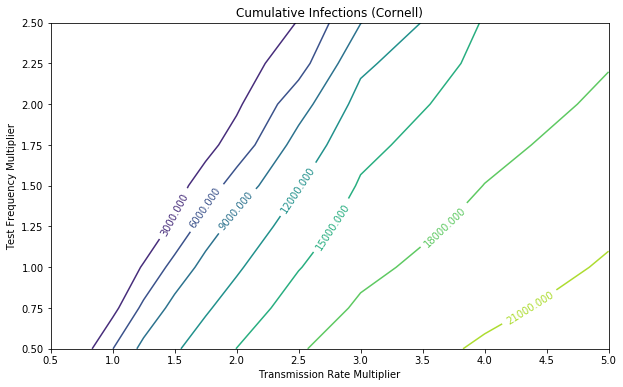

In [94]:
# X - Transmission Rate, Y - Test Frequency
file = open('res_inst_paper_graphs/mar_19_contour_tr_test_freq_v2.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X, X_list, Y, Y_list] = dill.load(file)
file.close()

contour_plot(X_list, Y_list, Zs_cornell_inf, 'Transmission Rate Multiplier', 'Test Frequency Multiplier', 'Cumulative Infections (Cornell)')

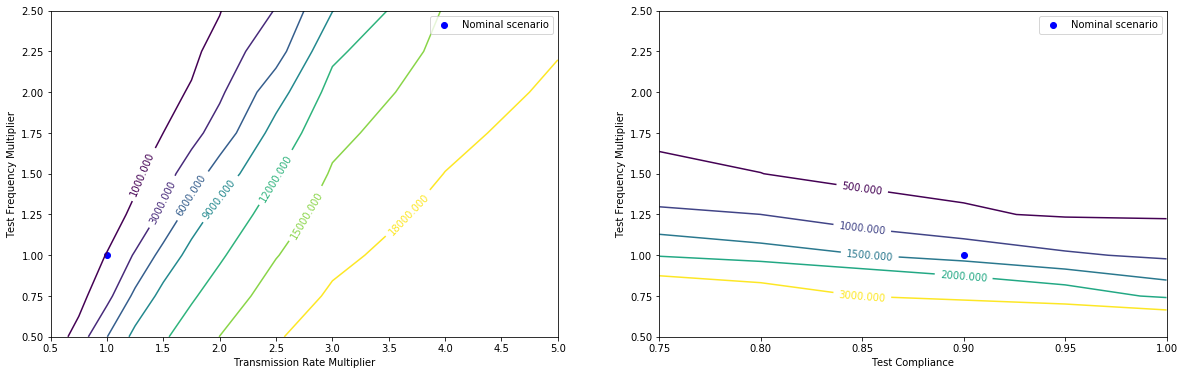

In [119]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1,2,1)

# X - Transmission Rate, Y - Test Frequency
file = open('res_inst_paper_graphs/mar_19_contour_tr_test_freq_v2.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X, X_list, Y, Y_list] = dill.load(file)
file.close()

# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'

# plt.title(title)
plt.ylabel('Test Frequency Multiplier')
plt.xlabel('Transmission Rate Multiplier')
CS = plt.contour(np.array(X_list), np.array(Y_list), np.array(Zs_cornell_inf).T, [1000, 3000, 6000, 9000, 12000, 15000, 18000])
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(1,1,label='Nominal scenario', color='blue')
plt.legend()


plt.subplot(1,2,2)

# X - Test Compliance, Y - Test Frequency
file = open('res_inst_paper_graphs/contour_test_compliance_test_freq.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X, X_list, Y, Y_list] = dill.load(file)
file.close()

# plt.title(title)
plt.ylabel('Test Frequency Multiplier')
plt.xlabel('Test Compliance')
CS = plt.contour(np.array(X_list), np.array(Y_list), np.array(Zs_cornell_inf).T, [500, 1000, 1500, 2000, 3000])
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(0.9,1,label='Nominal scenario', color='blue')
plt.legend()


# plt.subplot(1,3,3)

# # Contour: X - Student Prevalence, Y - test freq
# file = open('res_inst_paper_graphs/contour_prevalence_test_freq.dill', mode='rb')
# [Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X, X_list, Y, Y_list] = dill.load(file)
# file.close()

# # plt.title(title)
# plt.ylabel('Test Frequency Multiplier')
# plt.xlabel('Student Prevalence')
# CS = plt.contour(np.array(X_list), np.array(Y_list), np.array(Zs_cornell_inf).T, [600, 800, 1000, 1200, 1500, 2000, 2500])
# # CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# # plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
# plt.clabel(CS, inline=1, fontsize=10)
# plt.scatter(0.0019,1,label='Nominal scenario', color='blue')
# plt.legend()
# plt.xlim(0.001,0.2)
# plt.xscale('log')

# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/contour_TR_compliance_test_freq.png', dpi=450)

In [96]:
sorted(X_list)

[0.75, 0.8, 0.85, 0.9, 0.95, 1]

# Sensitivity vs. Compliance

In [97]:
# Contour: X - test compliance, Y - test sensitivity
# p_test_compliance_test_sensitivity = run_new_process('test compliance', 'test sensitivity', X_test_compliance, Y_test_sensitivity, 'res_inst_paper_graphs/test_compliance_test_sensitivity.dill', 2036)

# Contour: X - test compliance, Y - test sensitivity
p_test_compliance_test_sensitivity = run_new_process('test compliance', 'test sensitivity', X_test_compliance, Y_test_sensitivity, 'res_inst_paper_graphs/mar_19_test_compliance_test_sensitivity_v2.dill', 2036)

# p_test_compliance_test_sensitivity.terminate()

Evaluating this:  test compliance 0.5 test sensitivity 0.5
Evaluating this:  test compliance 0.5 test sensitivity 0.55
Evaluating this:  test compliance 0.5 test sensitivity 0.6
Evaluating this:  test compliance 0.5 test sensitivity 0.65
Evaluating this:  test compliance 0.5 test sensitivity 0.7
Evaluating this:  test compliance 0.5 test sensitivity 0.75
Evaluating this:  test compliance 0.5 test sensitivity 0.8
Evaluating this:  test compliance 0.5 test sensitivity 0.85
Evaluating this:  test compliance 0.5 test sensitivity 0.9
Evaluating this:  test compliance 0.6 test sensitivity 0.5
Evaluating this:  test compliance 0.6 test sensitivity 0.55
Evaluating this:  test compliance 0.6 test sensitivity 0.6
Evaluating this:  test compliance 0.6 test sensitivity 0.65
Evaluating this:  test compliance 0.6 test sensitivity 0.7
Evaluating this:  test compliance 0.6 test sensitivity 0.75
Evaluating this:  test compliance 0.6 test sensitivity 0.8
Evaluating this:  test compliance 0.6 test sensit

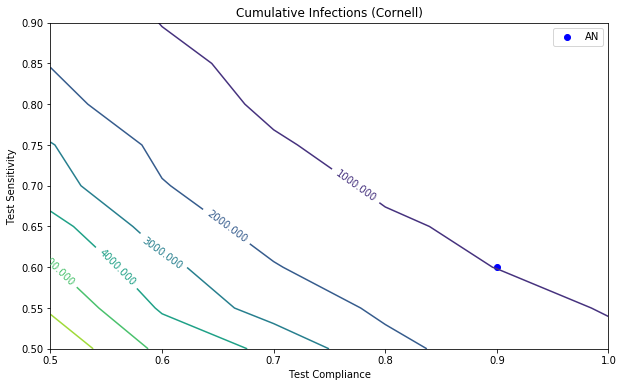

In [120]:
# Contour: X - test compliance, Y - test sensitivity
file = open('res_inst_paper_graphs/mar_19_test_compliance_test_sensitivity_v2.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_cornell_inf, X, X_list, Y, Y_list] = dill.load(file)
file.close()

# contour_plot(X_list, Y_list, Zs_cornell_inf, 'Test Compliance', 'Test Sensitivity', 'Cumulative Infections (Cornell)')

f, axs = plt.subplots(figsize=(10,6))

# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'

plt.title('Cumulative Infections (Cornell)')
plt.ylabel('Test Sensitivity')
plt.xlabel('Test Compliance')
CS = plt.contour(np.array(X_list), np.array(Y_list), np.array(Zs_cornell_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(0.9, 0.6, color='blue', label='AN')
plt.legend()
# plt.show()

plt.savefig('res_inst_paper_graphs/mar_19_graphs/contour_compliance_sensitivity.png', dpi=450)

# Trajectories

In [126]:
def get_trajectories(params_list, interaction_matrix, group_names, T, n):
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    trajectories = list()
    
    for _ in range(n):
        sim.run_new_trajectory(T)
        group_results = []
        for group in sim.sims:
            df = group.sim_df
            group_results.append(df)
        trajectories.append(group_results)

    return trajectories

In [127]:
np.random.seed(2040)
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

# inperson_normal = list()
print('Evaluating this policy: ', testing_policy)

params_list, interaction_matrix, group_names = get_nominal_params()
nominal_trajectories = get_trajectories(params_list, interaction_matrix, group_names, 112, 25)

params_list, interaction_matrix, group_names = get_optimistic_params()
optimistic_trajectories = get_trajectories(params_list, interaction_matrix, group_names, 112, 25)

params_list, interaction_matrix, group_names = get_pessimistic_params()
pessimistic_trajectories = get_trajectories(params_list, interaction_matrix, group_names, 112, 25)


Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [128]:
file = open('res_inst_paper_graphs/mar_19_graphs/trajectory_fig_data.dill', mode='wb')
dill.dump([nominal_trajectories, optimistic_trajectories, pessimistic_trajectories], file)
file.close()

In [12]:
file = open('res_inst_paper_graphs/mar_19_graphs/trajectory_fig_data.dill', mode='rb')
[nominal_trajectories, optimistic_trajectories, pessimistic_trajectories] = dill.load(file)
file.close()

In [129]:
def get_cornell_inf_traj(trajectory):
    cornell_inf_traj = np.zeros(trajectory[0].shape[0])
    for group_df in trajectory[:-1]:
        cornell_inf_traj += get_cum_inf_trajectory(group_df)
    return cornell_inf_traj

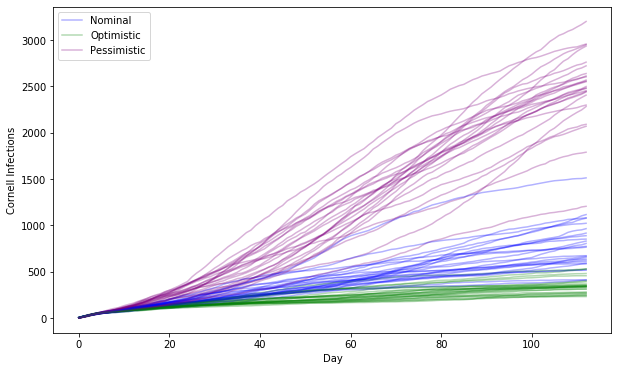

In [130]:
plt.figure(figsize=(10,6))
label = True
for nominal_traj, optimistic_traj, pessimistic_traj in zip(nominal_trajectories, optimistic_trajectories, pessimistic_trajectories):
    if label:
        plt.plot(get_cornell_inf_traj(nominal_traj), color = 'blue', alpha = 0.3, label='Nominal')
        plt.plot(get_cornell_inf_traj(optimistic_traj), color = 'green', alpha=0.3, label='Optimistic')
        plt.plot(get_cornell_inf_traj(pessimistic_traj), color = 'purple', alpha=0.3, label='Pessimistic')
        plt.legend(loc='best')
        label = False
    else:
        plt.plot(get_cornell_inf_traj(nominal_traj), color='blue', alpha = 0.3)
        plt.plot(get_cornell_inf_traj(optimistic_traj), color='green', alpha=0.3)
        plt.plot(get_cornell_inf_traj(pessimistic_traj), color='purple', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cornell Infections')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/trajectories.png', dpi=450)

(113, 70)

# Calibrated Graphs

##### Faculty/Staff Trajectory code

In [47]:
base_params_free = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_post_movein_private.yaml')[1]
base_params_selfiso = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_pre_semester_private.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [370]:
outside_infection_week = pd.DataFrame({'week':list(range(34,53)), 'new_weekly_cases':[0,0,0,0,0.000014,0,0,0.000056,0.000097,0.000014,0.000125,0.000083,0.000125,0.000194,0.000167,0.000320,0.000306,0.000264,0.000320]})

In [48]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 10283 
base_params_free['test_population_fraction'] = 0 
base_params_free['test_protocol_QFNR'] =.43
# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
#base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] =0.098 #weighted average for students, weighted average for faculty and staff
base_params_free['test_protocol_QFNR'] = .43
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 10283
new_population_counts = [int(count) for count in """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])


def init_movein_sim(transmissions_per_contact, isolations_per_trace=None, outside_infection_week = None):
    avg_init_cases = 0
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['outside_infection_p_array'] = outside_infection_week
    
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
        base_params_post_movein['cases_isolated_per_contact']=isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
        
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [372]:
actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
actual_counts = actuals['cum_case_count']
len(actual_counts)

148

In [373]:
def sample_movein_trajectory(transmission_p, isos_per_trace=None,outside_infection_week = None):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace,outside_infection_week)
    # for each day
    for i in range(len(actual_counts)-1):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return df

def sample_FS_trajectories(transmission_p, ntrajectories, isos_per_trace=None, outside_infection_week = None):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_movein_trajectory(transmission_p, isos_per_trace,outside_infection_week)
        trajectories.append(t)
    return trajectories

In [383]:
sample_FS_trajectories(0.015,1,None,outside_infection_week)[0].columns

Index(['S', 'QS', 'QI', 'R', 'E_0', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6',
       'pre_ID_0', 'pre_ID_1', 'pre_ID_2', 'pre_ID_3', 'ID_0', 'ID_1', 'ID_2',
       'ID_3', 'ID_4', 'ID_5', 'ID_6', 'ID_7', 'SyID_mild_0', 'SyID_mild_1',
       'SyID_mild_2', 'SyID_mild_3', 'SyID_mild_4', 'SyID_mild_5',
       'SyID_mild_6', 'SyID_mild_7', 'SyID_mild_8', 'SyID_mild_9',
       'SyID_mild_10', 'SyID_mild_11', 'SyID_mild_12', 'SyID_mild_13',
       'SyID_mild_14', 'SyID_mild_15', 'SyID_mild_16', 'SyID_mild_17',
       'SyID_mild_18', 'SyID_mild_19', 'SyID_severe_0', 'SyID_severe_1',
       'SyID_severe_2', 'SyID_severe_3', 'SyID_severe_4', 'SyID_severe_5',
       'SyID_severe_6', 'SyID_severe_7', 'SyID_severe_8', 'SyID_severe_9',
       'SyID_severe_10', 'SyID_severe_11', 'SyID_severe_12', 'SyID_severe_13',
       'SyID_severe_14', 'SyID_severe_15', 'SyID_severe_16', 'SyID_severe_17',
       'SyID_severe_18', 'SyID_severe_19', 'cumulative_mild',
       'cumulative_severe', 'cumulative_outside

In [394]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        FS_df = sample_FS_trajectories(0.015,1,None,outside_infection_week)[0]
        result[0].append(get_cum_infections(FS_df.head(T)))
#         result[1].append(get_cum_hosp(FS_df))
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [395]:
load_params('../src/simulations_v2/params/jan4calibration/group_1_students_post_movein_private.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


{'severity_prevalence': array([0.47808584, 0.50907724, 0.00940271, 0.00343422]),
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'mild_symptoms_daily_self_report_p': 0,
 'cases_isolated_per_contact': 1.329,
 'cases_quarantined_per_contact': 3.304,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'daily_outside_infection_p': 

In [396]:
def get_calibrated_params():
    
    g1_params = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_post_movein_private.yaml')[1]
    g2_params = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_post_movein_private.yaml')[1]
    g3_params = load_params('../src/simulations_v2/params/jan4calibration/group_3_students_post_movein_private.yaml')[1]

    g1_params['exposed_infection_p'] = 0.485
    g2_params['exposed_infection_p'] = 0.485
    g3_params['exposed_infection_p'] = 0.485
    
    g1_params['population_size'] = 3533
    g2_params['population_size'] = 8434
    g3_params['population_size'] = 6202
    
    g1_params['severe_symptoms_daily_self_report_p'] = 0.22
    g2_params['severe_symptoms_daily_self_report_p'] = 0.22
    g3_params['severe_symptoms_daily_self_report_p'] = 0.22
    
    g1_params['initial_ID_prevalence'] = 5.77 / 3533
    g2_params['initial_ID_prevalence'] = 3.37 / 8434
    
    
    # NEED TO ADD FACULTY/STAFF group
    
    
    interaction_matrix = np.array([[92/125, 1/44, 0],
                                  [3.5/125, 6.5/44, 0],
                                  [0,1/44,1/15]])

    group_names = ['UG (Greek + Athlete)', 'UG (other)', 'GS']
    
    params_list = [g1_params.copy(), g2_params.copy(), g3_params.copy()]
    return params_list, interaction_matrix, group_names

In [397]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

In [398]:
np.random.seed(2025)
params_list, interaction_matrix, group_names = get_calibrated_params()

In [399]:
limited_policies = [[1/7,1/7,1/7],
[2/7,1/7,1/7],
[2/7,2/7,1/7],
[2/7,1/7,2/7],
[2/7,2/7,2/7],
[3/7,1/7,1/7],
[3/7,2/7,1/7],
[3/7,3/7,1/7]]

In [400]:
results_baseline = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 100)
    results_baseline.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.2857142857142857]
Evaluating this policy:  [0.42857142857142855, 0.14285714285714285, 0.14285714285714285]
Evaluating this policy:  [0.42857142857142855, 0.2857142857142857, 0.14285714285714285]
Evaluating this policy:  [0.42857142857142855, 0.42857142857142855, 0.14285714285714285]


In [401]:
plotting_data = generate_plotting_matrix(results_baseline)
FS_tests_per_day = (base_params_post_movein['test_population_fraction']) * (base_params_post_movein['population_size'])
plotting_data['daily_tests'] += FS_tests_per_day

In [402]:
file = open('res_inst_paper_graphs/mar_19_graphs/calibrated_testing_pareto_data_v2.dill', mode='wb')
dill.dump([plotting_data], file)
file.close()

In [ ]:
[plotting_data] = dill.load(open('res_inst_paper_graphs/mar_19_graphs/calibrated_testing_pareto_data_v2.dill', mode='rb'))

In [403]:
plotting_data

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,hosp_yerr_low,hosp_yerr_high,cornell_inf_yerr_low,cornell_inf_yerr_high,cornell_hosp_yerr_low,cornell_hosp_yerr_high,ithaca_inf_yerr_low,ithaca_inf_yerr_high,ithaca_hosp_yerr_low,ithaca_hosp_yerr_high
0,2595.571429,668.0,218.6,1320.4,7.391056,1.057622,14.750138,565.5,82.0,1149.3,...,6.333434,7.359082,483.5,583.8,6.321136,7.373839,69.5,97.7,0.061490,0.110681
1,3100.285714,215.5,119.4,324.8,0.737876,0.464862,1.259308,59.5,37.0,104.6,...,0.273014,0.521432,22.5,45.1,0.233661,0.602599,77.8,103.1,0.051651,0.049192
2,4305.142857,201.0,134.6,320.1,0.700982,0.489458,1.205197,56.0,38.0,94.4,...,0.211524,0.504215,18.0,38.4,0.245959,0.447645,74.9,102.6,0.049192,0.049192
3,3986.285714,181.0,126.5,318.3,0.762472,0.516513,1.278985,57.5,39.8,98.1,...,0.245959,0.516513,17.7,40.6,0.270554,0.516513,70.5,128.1,0.049192,0.051651
4,5191.142857,195.5,110.9,337.1,0.762472,0.442726,1.377368,59.0,35.8,103.4,...,0.319746,0.614897,23.2,44.4,0.319746,0.597679,81.7,95.7,0.049192,0.073788
5,3605.000000,182.5,102.7,285.0,0.541109,0.368938,0.787068,41.0,31.9,61.0,...,0.172171,0.245959,9.1,20.0,0.159873,0.236120,70.1,109.2,0.024596,0.073788
6,4809.857143,167.0,102.0,274.1,0.541109,0.366478,0.811663,41.0,30.0,63.1,...,0.174631,0.270554,11.0,22.1,0.184469,0.233661,64.3,101.7,0.049192,0.049192
7,6014.714286,171.5,106.0,289.3,0.541109,0.368938,0.787068,42.0,30.0,60.0,...,0.172171,0.245959,12.0,18.0,0.172171,0.270554,61.6,127.3,0.024596,0.073788


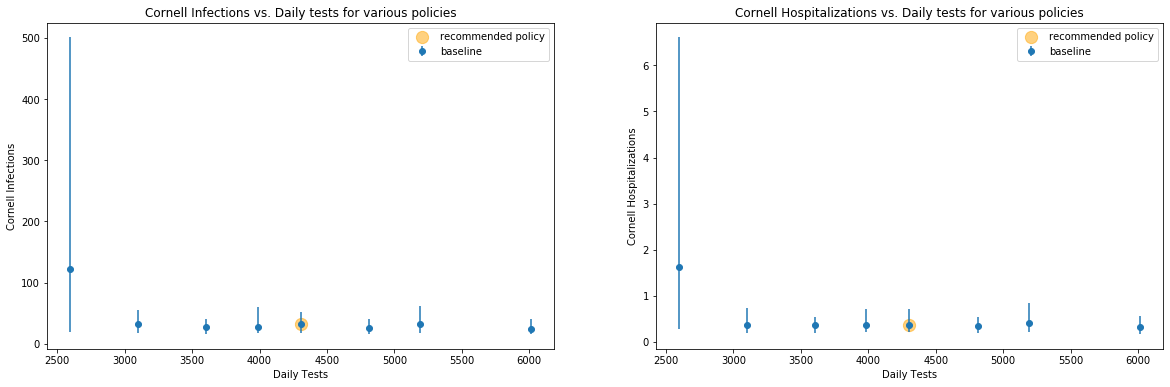

In [95]:
### MAKE SURE NEW GRAPHS USE TOTAL INFECTIONS (NOT CORNELL INFECTIONS)

selected_policy_index = 2

f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

# plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
# plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# # for index in range(len(text_x)):
# #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
# plt.title('Infections vs. Daily tests for various policies')
# plt.ylabel('Infections')
# plt.xlabel('Daily Tests')
# plt.legend()

# plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
# plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# # for index in range(len(text_x)):
# #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
# plt.title('Hospitalizations vs. Daily tests for various policies')
# plt.ylabel('Hospitalizations')
# plt.xlabel('Daily Tests')
# plt.legend()
# plt.show()

plt.subplot(1,2,1)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()


plt.subplot(1,2,2)
plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

# plt.savefig('res_inst_paper_graphs/testing_policy.png', dpi=450)

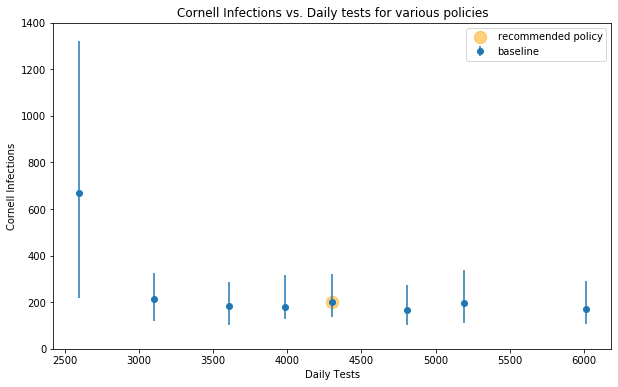

In [411]:
### MAKE SURE NEW GRAPHS USE TOTAL INFECTIONS (NOT CORNELL INFECTIONS)

selected_policy_index = 2

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

plt.subplot(1,1,1)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.ylim([0,1400])
plt.legend()
# plt.show()

plt.savefig('res_inst_paper_graphs/mar_19_graphs/virtual_calibrated_testing_policy.png', dpi=450)

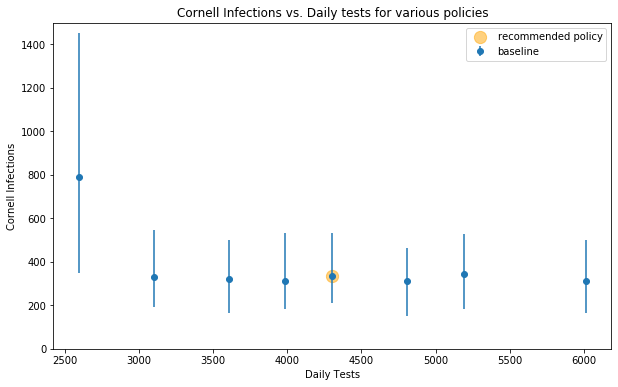

In [391]:
### MAKE SURE NEW GRAPHS USE TOTAL INFECTIONS (NOT CORNELL INFECTIONS)

selected_policy_index = 2

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

plt.subplot(1,1,1)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.ylim([0,1500])
plt.legend()
plt.show()

# plt.savefig('res_inst_paper_graphs/mar_19_graphs/virtual_calibrated_testing_policy.png', dpi=450)

## Contour Plot (returning students)

In [405]:
np.random.seed(2026)

In [406]:
def get_calibrated_virtual_params(popsize, perc_compliant):
    
    g1_comp_params = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_post_movein_private.yaml')[1]
    g1_non_comp_params = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_post_movein_private.yaml')[1]
    g2_comp_params = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_post_movein_private.yaml')[1]
    g2_non_comp_params = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_post_movein_private.yaml')[1]
    g3_params = load_params('../src/simulations_v2/params/jan4calibration/group_3_students_post_movein_private.yaml')[1]

    g1_popsize = np.ceil(popsize * 3533/(3533+8438))
    g2_popsize = popsize - g1_popsize
    
    g1_comp_params['exposed_infection_p'] = 0.485
    g1_non_comp_params['exposed_infection_p'] = 0.485
    g2_comp_params['exposed_infection_p'] = 0.485
    g2_non_comp_params['exposed_infection_p'] = 0.485
    g3_params['exposed_infection_p'] = 0.485
    
    g1_comp_params['population_size'] = int(np.ceil(g1_popsize * perc_compliant))
    g1_non_comp_params['population_size'] = g1_popsize - g1_comp_params['population_size']
    g2_comp_params['population_size'] = int(np.ceil(g2_popsize * perc_compliant))
    g2_non_comp_params['population_size'] = g2_popsize - g2_comp_params['population_size']
    g3_params['population_size'] = 6202

    g1_comp_params['severe_symptoms_daily_self_report_p'] = 0.22
    g1_non_comp_params['severe_symptoms_daily_self_report_p'] = 0.22
    g2_comp_params['severe_symptoms_daily_self_report_p'] = 0.22
    g2_non_comp_params['severe_symptoms_daily_self_report_p'] = 0.22
    g3_params['severe_symptoms_daily_self_report_p'] = 0.22

    
    g1_comp_params['initial_ID_prevalence'] = 5.77 / 3533
    g1_non_comp_params['initial_ID_prevalence'] = 5.77 / 3533
    g2_comp_params['initial_ID_prevalence'] = 3.37 / 8434
    g2_non_comp_params['initial_ID_prevalence'] = 3.37 / 8434
    
    g1_non_comp_params['test_protocol_QFNR'] = 0.7
    g2_non_comp_params['test_protocol_QFNR'] = 0.7
    
    # NEED TO ADD INITIAL ID PREVALENCE (currently 0)
    
    interaction_matrix = np.array([[92/125 * perc_compliant, 92/125 * (1-perc_compliant), 1/44 * (perc_compliant), 1/44 * (1 - perc_compliant), 0],
                                  [92/125 * perc_compliant, 92/125 * (1-perc_compliant), 1/44 * (perc_compliant), 1/44 * (1 - perc_compliant), 0],
                                  [3.5/125 * perc_compliant, 3.5/125 * (1-perc_compliant), 6.5/44 * perc_compliant, 6.5/44 * (1-perc_compliant), 0],
                                  [3.5/125 * perc_compliant, 3.5/125 * (1-perc_compliant), 6.5/44 * perc_compliant, 6.5/44 * (1-perc_compliant), 0],
                                  [0,0,1/44*perc_compliant,1/44*(1-perc_compliant),1/15]])

    group_names = ['UG (Greek + Athlete) compliant', 'UG (Greek + Athlete) non-compliant', 'UG (other) compliant', 'UG (other) non-compliant', 'GS']
    
    params_list = [g1_comp_params.copy(), g1_non_comp_params.copy(), g2_comp_params.copy(), g2_non_comp_params.copy(), g3_params.copy()]
    return params_list, interaction_matrix, group_names

In [407]:
X_popsize = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
Y_compliant = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

Zs_hosp = []
Zs_inf = []
Zs_UG_hosp = []
Zs_UG_inf = []

for popsize in X_popsize:
    
    Z_hosp = []
    Z_inf = []
    Z_UG_hosp = []
    Z_UG_inf = []
    for perc_compliant in Y_compliant:
#for (contacts, popsize), dfs in sensitivity_output.sim_results['Nominal Student Parameters'].items():
        testing_policy = [2/7,0,2/7,0,1/7]
    
        params_list, interaction_matrix, group_names = get_calibrated_virtual_params(popsize, perc_compliant)
        
        virtual_normal = list()
        
        print('Evaluating this: ', popsize, perc_compliant)
        tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)

        virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})        
        
        Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
        Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
        Z_UG_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
        Z_UG_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))        

    Zs_hosp.append(Z_hosp)
    Zs_inf.append(Z_inf)
    Zs_UG_hosp.append(Z_UG_hosp)
    Zs_UG_inf.append(Z_UG_inf)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Evaluating this:  2000 0.01
Evaluating this:  2000 0.1
Evaluating this:  2000 0.2
Evaluating this:  2000 0.3
Evaluating this:  2000 0.4
Evaluating this:  2000 0.5
Evaluating this:  2000 0.6
Evaluating this:  2000 0.7
Evaluating this:  2000 0.8
Evaluating this:  2000 0.9
Evaluating this:  2000 0.99
Evaluating this:  3000 0.01
Evaluating this:  3000 0.1
Evaluating this:  3000 0.2
Evaluating this:  3000 0.3
Evaluating this:  3000 0.4
Evaluating this:  3000 0.5
Evaluating this:  3000 0.6
Evaluating this:  3000 0.7
Evaluating this:  3000 0.8
Evaluating this:  3000 0.9
Evaluating this:  3000 0.99
Evaluating this:  4000 0.01
Evaluating this:  4000 0.1
Evaluating this:  4000 0.2
Evaluating this:  4000 0.3
Evaluating this:  4000 0.4
Evaluating this:  4000 0.5
Evaluating this:  4000 0.6
Evaluating this:  4000 0.7
Evaluating this:  4000 0.8
Evaluating this:  4000 0.9
Evaluating this:  4000 0.99
Evaluating this:  5000 0.01
Evaluating this:  5000 0.1
Evaluating this:  5000 0.2
Evaluating this:  500

In [408]:
file = open('res_inst_paper_graphs/mar_19_graphs/calibrated_virtual_contour_v2.dill', mode='wb')
dill.dump([Zs_hosp, Zs_inf, Zs_UG_hosp, Zs_UG_inf, X_popsize, Y_compliant], file)
file.close()

In [ ]:
file = open('res_inst_paper_graphs/mar_19_graphs/calibrated_virtual_contour.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_UG_inf, X_popsize, Y_compliant] = dill.load(file)
file.close()

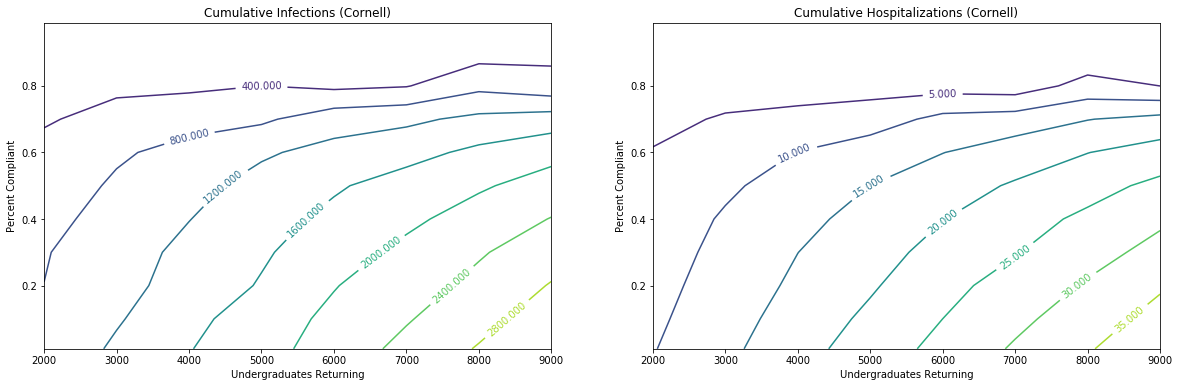

In [409]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,2,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant), np.array(Zs_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)


plt.subplot(1,2,2)
plt.title("Cumulative Hospitalizations (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant), np.array(Zs_hosp).T)
# pop_levels = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]
# pop_labels = dict()
# for level in pop_levels:
#     pop_labels[level] = str(level*100) + '%'
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_hosp).T/34310, pop_levels)
# plt.clabel(CS, fmt=pop_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()


# plt.savefig('res_inst_paper_graphs/test_freq_tr_mult_contour.jpg', dpi=450)

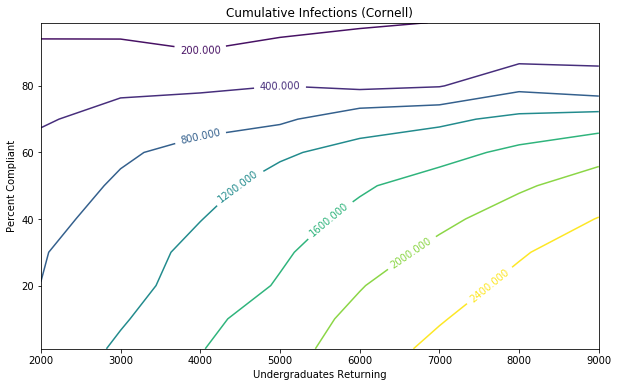

In [410]:
file = open('res_inst_paper_graphs/mar_19_graphs/calibrated_virtual_contour_v2.dill', mode='rb')
[Zs_hosp, Zs_inf, Zs_cornell_hosp, Zs_UG_inf, X_popsize, Y_compliant] = dill.load(file)
file.close()

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

inf_levels = [100, 200, 400, 800, 1200, 1600, 2000, 2400]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,1,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
# CS = plt.contour(np.array(X_popsize), 100*np.array(Y_compliant), np.array(Zs_inf).T)
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant) * 100, np.array(Zs_inf).T, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)

# plt.show()


plt.savefig('res_inst_paper_graphs/mar_19_graphs/virtual_test_freq_tr_mult_contour.jpg', dpi=450)

# Trajectory Graphs

### Student Calibration Code

In [325]:
movein_selfiso_params = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]

g1_base_params_free  = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_pre_semester_private.yaml')[1]
g1_base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_post_movein_private.yaml')[1]

g2_base_params_free  = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_pre_semester_private.yaml')[1]
g2_base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_post_movein_private.yaml')[1]


g3_base_params_free  = load_params('../src/simulations_v2/params/jan4calibration/group_3_students_pre_semester_private.yaml')[1]
g3_base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/group_3_students_post_movein_private.yaml')[1]

movein_selfiso_params['severe_symptoms_daily_self_report_p'] = 0.22
g1_base_params_free['severe_symptoms_daily_self_report_p'] = 0.22
g1_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.22
g2_base_params_free['severe_symptoms_daily_self_report_p'] = 0.22
g2_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.22
g3_base_params_free['severe_symptoms_daily_self_report_p'] = 0.22
g3_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.22


#Load Actuals

actuals1 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_1.csv')
actuals2 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_2.csv')
actuals3 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_3.csv')


actual_counts1 = actuals1['cum_case_count']
actual_counts2 = actuals2['cum_case_count']
actual_counts3 = actuals3['cum_case_count']


g1_movein_contact_matrix = np.matrix([
    [g1_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g2_movein_contact_matrix = np.matrix(
   [ [g2_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g3_movein_contact_matrix = np.matrix(
   [ [g3_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

In [326]:
def sample_movein_trajectory(transmission_p, T=110):
    
    movein_time_horizon = 18

    init_pop_count = 513
    avg_init_cases = 5.77
    new_population_counts = [int(count) for count in """108
    141
    90
    87
    88
    71
    126
    539
    469
    124
    304
    76
    211
    105
    231
    99
    102
    49""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g1_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g1_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}



    init_pop_count = 1222
    avg_init_cases = 3.37
    new_population_counts = [int(count) for count in """259
    337
    216
    207
    210
    169
    300
    1287
    1119
    295
    727
    182
    504
    251
    552
    237
    244
    116""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g2_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g2_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}


    init_pop_count = 5281
    avg_init_cases = 0
    new_population_counts = [int(count) for count in """42
    64
    39
    58
    101
    57
    60
    59
    51
    43
    41
    30
    24
    42
    40
    47
    34
    89""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g3_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g3_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
    
    
    
    g1_base_params_free['exposed_infection_p'] = transmission_p
    g1_base_params_post_movein['exposed_infection_p'] = transmission_p
    g2_base_params_free['exposed_infection_p'] = transmission_p
    g2_base_params_post_movein['exposed_infection_p'] = transmission_p
    g3_base_params_free['exposed_infection_p'] = transmission_p
    g3_base_params_post_movein['exposed_infection_p'] = transmission_p
    
    
    g1_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g1_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    g2_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g2_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    g3_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g3_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    
    dynamic_pop_sim1 = DynamicPopulationSim(
        g1_base_params_free,
        movein_selfiso_params,
        g1_base_params_post_movein,
        g1_movein_contact_matrix,
        movein_time_horizon,
        g1_free_group_population_dynamics,
        {}
    )

    dynamic_pop_sim2 = DynamicPopulationSim(
        g2_base_params_free,
        movein_selfiso_params,
        g2_base_params_post_movein,
        g2_movein_contact_matrix,
        movein_time_horizon,
        g2_free_group_population_dynamics,
        {}
    )

    dynamic_pop_sim3 = DynamicPopulationSim(
        g3_base_params_free,
        movein_selfiso_params,
        g3_base_params_post_movein,
        g3_movein_contact_matrix,
        movein_time_horizon,
        g3_free_group_population_dynamics,
        {}
    )
    
    
    contact_matrix = np.matrix([[0.736, 0.023, 0],[.028, .148, 0], [0, 0.023, .067]])
    
    
    multigroup_sim = MultiGroupSimulationDynamicPopulation([dynamic_pop_sim1, dynamic_pop_sim2,dynamic_pop_sim3], contact_matrix)
    for _ in range(0,T):
        multigroup_sim.step()

    movein_df = dynamic_pop_sim1.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim1.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r1 = df
    
    movein_df = dynamic_pop_sim2.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim2.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r2 = df
    
    movein_df = dynamic_pop_sim3.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim3.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r3 = df
    
    return [r1,r2,r3]

def sample_trajectories(transmission_p, ntrajectories):
    print(transmission_p)
    g1_trajectories = []
    g2_trajectories = []
    g3_trajectories = []
    for _ in range(ntrajectories):
        t =sample_movein_trajectory(transmission_p)
        g1_trajectories.append(t[0])
        g2_trajectories.append(t[1])
        g3_trajectories.append(t[2])
    return [g1_trajectories,g2_trajectories,g3_trajectories]

In [294]:
from analysis_helpers import binomial_exit_function
from dynamic_population_sim import DynamicPopulationSim
from multi_group_simulation_dynamic_population import MultiGroupSimulationDynamicPopulation
student_trajectories = sample_trajectories(0.485, 100)

0.485


In [295]:
# Average calibrated student trajectory
g1_avg_trajs = list()
for g1_traj in student_trajectories[0]:
    g1_avg_trajs.append(get_cum_inf_trajectory(g1_traj))
g1_avg_traj = np.mean(g1_avg_trajs, axis=0)

g2_avg_trajs = list()
for g2_traj in student_trajectories[1]:
    g2_avg_trajs.append(get_cum_inf_trajectory(g2_traj))
g2_avg_traj = np.mean(g2_avg_trajs, axis=0)

g3_avg_trajs = list()
for g3_traj in student_trajectories[2]:
    g3_avg_trajs.append(get_cum_inf_trajectory(g3_traj))
g3_avg_traj = np.mean(g3_avg_trajs, axis=0)

## Faculty Calibration Code

In [328]:
base_params_free = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_post_movein_private.yaml')[1]
base_params_selfiso = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_pre_semester_private.yaml')[1]

In [329]:
# outside_infection_week = pd.read_csv('outside_infection_staff.csv')
# outside_infection_week = outside_infection_week.drop('Unnamed: 0', axis = 1)

# weeks = list(outside_infection_week['week'].values)
# cases = [0,
# 0,
# 0,
# 0,
# 1,
# 0,
# 0,
# 4,
# 7,
# 1,
# 9,
# 6,
# 9,
# 14,
# 12,
# 23,
# 22,
# 19,
# 23,
# 12]

# # quick patch since last week is january
# import datetime
# print(datetime.datetime(2021,1,4).isocalendar()[1])

# weeks.append(1)
# cases.append(22)
# outside_infection_week = pd.DataFrame(np.column_stack((weeks,cases)), columns = ['week','new_weekly_cases'])
# outside_infection_week['new_weekly_cases'] = outside_infection_week['new_weekly_cases']/(7*(10283))
# # outside_infection_week

outside_infection_week = pd.DataFrame({'week':list(range(34,53)), 'new_weekly_cases':[0,0,0,0,0.000014,0,0,0.000056,0.000097,0.000014,0.000125,0.000083,0.000125,0.000194,0.000167,0.000320,0.000306,0.000264,0.000320]})

In [330]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 10283 
base_params_free['test_population_fraction'] = 0 
base_params_free['test_protocol_QFNR'] =.43
# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
#base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] =0.098 #weighted average for students, weighted average for faculty and staff
base_params_free['test_protocol_QFNR'] = .43
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 10283
new_population_counts = [int(count) for count in """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])


def init_movein_sim(transmissions_per_contact, isolations_per_trace=None, outside_infection_week = None):
    avg_init_cases = 0
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['outside_infection_p_array'] = outside_infection_week
    
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
        base_params_post_movein['cases_isolated_per_contact']=isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
        
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [331]:
actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
actual_counts = actuals['cum_case_count']
len(actual_counts)

148

In [332]:
def sample_movein_trajectory(transmission_p, isos_per_trace=None,outside_infection_week = None):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace,outside_infection_week)
    # for each day
    for i in range(len(actual_counts)-1):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return df

def sample_trajectories(transmission_p, ntrajectories, isos_per_trace=None, outside_infection_week = None):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_movein_trajectory(transmission_p, isos_per_trace,outside_infection_week)
        trajectories.append(t)
    return trajectories

In [261]:
staff_trajectories = sample_trajectories(0.015,100,None,outside_infection_week)

In [262]:
staff_avg_trajs = list()
for staff_traj in staff_trajectories:
    staff_avg_trajs.append(get_cum_inf_trajectory(staff_traj))
staff_avg_traj = np.mean(staff_avg_trajs, axis=0)

In [298]:
calibrated_cornell_traj = g1_avg_traj + g2_avg_traj + g3_avg_traj + staff_avg_traj[:len(g1_avg_traj)]

In [315]:
# Cornell_so_far[105], calibrated_cornell_traj[105], d_index, d_index_now

(187, 287.23, 105, 106)

### Cornell Calibration Graph

In [264]:
import datetime as dt
import matplotlib.dates as mdates

In [282]:
d_index = 63 + 42 #63 for 10/18
d_index_now= 64 + 42 #64 for 10/19

d_start = 16 #16 for 9/1
d_index_2w = d_index_now+14

dates_array = mdates.drange(dt.datetime(2020,8,16), dt.datetime(2021,1,8), dt.timedelta(days=1))
dates = mdates.num2date(dates_array)

In [316]:
nominal_final=np.loadtxt('nominal_final.csv')
opt_final=np.loadtxt('optimistic_final.csv')
pess_final=np.loadtxt('pessimistic_final.csv')
# Cornell_so_far = np.asarray(pd.read_csv('Cornell_so_far.csv')['Counts'][:d_index+1])-26
Cornell_so_far = np.asarray(pd.read_csv('res_inst_paper_graphs/Cornell_so_far_updated.csv')['Counts'][:d_index+2])

In [285]:
pd.read_csv('res_inst_paper_graphs/Cornell_so_far_updated.csv')

,date,Counts
0,8/16/2020,0
1,8/17/2020,0
2,8/18/2020,2
3,8/19/2020,3
4,8/20/2020,4
...,...,...
113,12/7/2020,199
114,12/8/2020,199
115,12/9/2020,200
116,12/10/2020,201


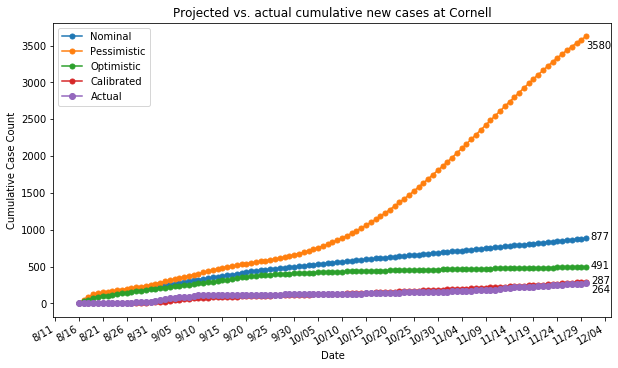

In [321]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dates[:d_index_now+1], nominal_final[:d_index_now+1], '-o', label='Nominal',linewidth=1.5,markersize=5)
ax.plot(dates[:d_index_now+1], pess_final[:d_index_now+1], '-o', label='Pessimistic',linewidth=1.5,markersize=5)
ax.plot(dates[:d_index_now+1], opt_final[:d_index_now+1], '-o', label='Optimistic',linewidth=1.5,markersize=5)
# ax.plot(dates[:len(calibrated_cornell_traj)], calibrated_cornell_traj, '-o', label='Calibrated', linewidth=1.5, markersize=5)
ax.plot(dates[:d_index_now+1], calibrated_cornell_traj[:d_index_now+1], '-o', label='Calibrated', linewidth=1.5, markersize=5)
ax.plot(dates[:len(Cornell_so_far)], Cornell_so_far, '-o', label='Actual')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()
ax.annotate(str(int(calibrated_cornell_traj[d_index])), (dates[d_index+2], calibrated_cornell_traj[d_index]-20))
ax.annotate(str(int(Cornell_so_far[d_index])), (dates[d_index+2], Cornell_so_far[d_index]-125))
ax.annotate(str(int(nominal_final[d_index])), (dates[d_index+2], nominal_final[d_index]-20))
ax.annotate(str(int(opt_final[d_index])), (dates[d_index+2], opt_final[d_index]-20))
ax.annotate(str(int(pess_final[d_index])), (dates[d_index+1], pess_final[d_index]-125))
# ax.annotate(str(int(nominal_final[d_index_now])), (dates[d_index_now], nominal_final[d_index_now]+10))
# ax.annotate(str(int(opt_final[d_index_now])), (dates[d_index_now], opt_final[d_index_now]+10))
# ax.annotate(str(int(pess_final[d_index_now])), (dates[d_index_now], pess_final[d_index_now]+10))

formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::5])



fig.autofmt_xdate()

# plt.title('Projected vs. actual cumulative new cases at Cornell since 8/16\n \
#         (Today: '+dates[d_index_now].strftime('%a, %-m/%d')+'; Actual data observed up to '
#           +dates[d_index].strftime('%a, %-m/%d')+')')

plt.title('Projected vs. actual cumulative new cases at Cornell')

plt.ylabel('Cumulative Case Count')
plt.xlabel('Date')

# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/scenarios_calibrated_actual_fall.jpg', dpi=450)

In [327]:
np.random.seed(2080)
student_trajectories = sample_trajectories(0.485, 100)

0.485


In [358]:
# staff_trajectories = sample_trajectories(0.015,100,None,outside_infection_week)

In [356]:
n_days = student_trajectories[0][0].shape[0]
trajs = list()
for g1_traj, g2_traj, g3_traj, staff_traj in zip(student_trajectories[0], student_trajectories[1], student_trajectories[2], staff_trajectories):
    trajs.append(np.array(get_cum_inf_trajectory(g1_traj))+ np.array(get_cum_inf_trajectory(g2_traj))+np.array(get_cum_inf_trajectory(g3_traj)) +np.array(get_cum_inf_trajectory(staff_traj)[:n_days]))

100

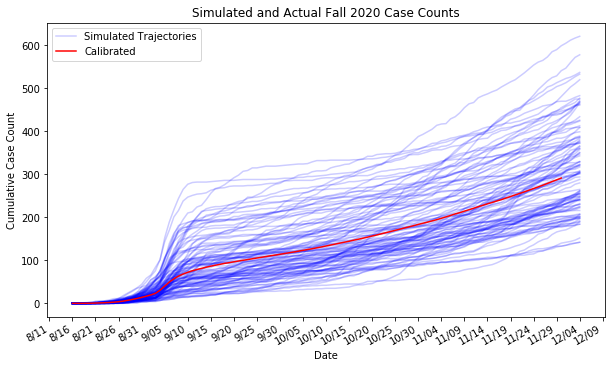

In [368]:
dates_array = mdates.drange(dt.datetime(2020,8,16), dt.datetime(2021,1,8), dt.timedelta(days=1))
dates = mdates.num2date(dates_array)


fig, ax = plt.subplots(figsize=(10,6))
label = True
for traj in trajs:
    if label:
        ax.plot(dates[:len(traj)], traj, color='blue', alpha=0.2, label='Simulated Trajectories')
        label = False
    else:
        ax.plot(dates[:len(traj)], traj, color='blue', alpha=0.2)

# ax.plot(dates[:d_index_now+1], calibrated_cornell_traj[:d_index_now+1], '-o', label='Calibrated', linewidth=1.5, markersize=5, color='red')
ax.plot(dates[:d_index_now+1], calibrated_cornell_traj[:d_index_now+1], label='Calibrated', linewidth=1.5, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::5])

fig.autofmt_xdate()

plt.title('Simulated and Actual Fall 2020 Case Counts')
plt.xlabel('Date')
plt.ylabel('Cumulative Case Count')

# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/calibrated_sim_trajs.jpg', dpi=450)

### Staff Calibration Graph

In [138]:
staff_actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
staff_actual_counts = np.asarray(staff_actuals['cum_case_count'])

In [ ]:
d_index = 63 #63 for 10/18
d_index_now= 64 #64 for 10/19

d_start = 16 #16 for 9/1
d_index_2w = d_index_now+14

dates_array = mdates.drange(dt.datetime(2020,8,16), dt.datetime(2021,1,8), dt.timedelta(days=1))
dates = mdates.num2date(dates_array)

In [ ]:
# NEED TO MAKE NEW NOMINAL / OPT / PESS trajectories for staff

# nominal_staff=np.loadtxt('nominal_staff.csv')
# opt_staff=np.loadtxt('optimistic_staff.csv')
# pess_staff=np.loadtxt('pessimistic_staff.csv')
# Cornell_so_far = np.asarray(pd.read_csv('Cornell_so_far.csv')['Counts'][:d_index+1])-26

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(dates[:d_index_now+1], nominal_final[:d_index_now+1], '-o', label='Nominal',linewidth=1.5,markersize=5)
# ax.plot(dates[:d_index_now+1], pess_final[:d_index_now+1], '-o', label='Pessimistic',linewidth=1.5,markersize=5)
# ax.plot(dates[:d_index_now+1], opt_final[:d_index_now+1], '-o', label='Optimistic',linewidth=1.5,markersize=5)
# ax.plot(dates[:len(calibrated_cornell_traj)], calibrated_cornell_traj, '-o', label='Calibrated', linewidth=1.5, markersize=5)
# ax.plot(dates[:d_index+1], Cornell_so_far, '-o', label='Actual')

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# ax.legend()
# ax.annotate(str(int(Cornell_so_far[-1])), (dates[d_index], Cornell_so_far[-1]-20))
# ax.annotate(str(int(nominal_final[d_index])), (dates[d_index], nominal_final[d_index]-20))
# ax.annotate(str(int(opt_final[d_index])), (dates[d_index], opt_final[d_index]-20))
# ax.annotate(str(int(pess_final[d_index])), (dates[d_index], pess_final[d_index]-20))
# ax.annotate(str(int(nominal_final[d_index_now])), (dates[d_index_now], nominal_final[d_index_now]+10))
# ax.annotate(str(int(opt_final[d_index_now])), (dates[d_index_now], opt_final[d_index_now]+10))
# ax.annotate(str(int(pess_final[d_index_now])), (dates[d_index_now], pess_final[d_index_now]+10))

# formatter = mdates.DateFormatter("%-m/%d")
# ax.xaxis.set_major_formatter(formatter)
# ax.set_xticks(ax.get_xticks()[::5])



# fig.autofmt_xdate()

# # plt.title('Projected vs. actual cumulative new cases at Cornell since 8/16\n \
# #         (Today: '+dates[d_index_now].strftime('%a, %-m/%d')+'; Actual data observed up to '
# #           +dates[d_index].strftime('%a, %-m/%d')+')')

# plt.title('Projected vs. actual cumulative new cases at Cornell')


# plt.show()

### Student Calibration Graphs

In [144]:
studentactuals1 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_1.csv')
studentactuals2 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_2.csv')
studentactuals3 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_3.csv')


student_actual_counts1 = np.asarray(studentactuals1['cum_case_count'])
student_actual_counts2 = np.asarray(studentactuals2['cum_case_count'])
student_actual_counts3 = np.asarray(studentactuals3['cum_case_count'])

student_actual_counts = student_actual_counts1 + student_actual_counts2 + student_actual_counts3
student_traj = g1_avg_traj + g2_avg_traj + g3_avg_traj

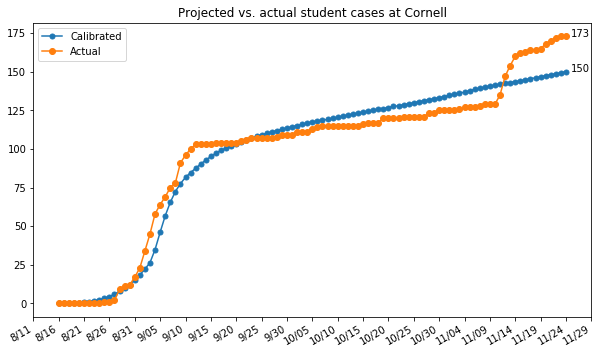

In [152]:
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(dates[:d_index_now+1], nominal_final[:d_index_now+1], '-o', label='Nominal',linewidth=1.5,markersize=5)
# ax.plot(dates[:d_index_now+1], pess_final[:d_index_now+1], '-o', label='Pessimistic',linewidth=1.5,markersize=5)
# ax.plot(dates[:d_index_now+1], opt_final[:d_index_now+1], '-o', label='Optimistic',linewidth=1.5,markersize=5)
ax.plot(dates[:len(student_traj)], student_traj, '-o', label='Calibrated', linewidth=1.5, markersize=5)
ax.plot(dates[:len(student_actual_counts)], student_actual_counts, '-o', label='Actual')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()
ax.annotate(str(int(student_traj[-1])), (dates[len(student_traj)], student_traj[-1]))
ax.annotate(str(int(student_actual_counts[-1])), (dates[len(student_actual_counts)], student_actual_counts[-1]))
# ax.annotate(str(int(Cornell_so_far[-1])), (dates[d_index], Cornell_so_far[-1]-20))
# ax.annotate(str(int(nominal_final[d_index])), (dates[d_index], nominal_final[d_index]-20))
# ax.annotate(str(int(opt_final[d_index])), (dates[d_index], opt_final[d_index]-20))
# ax.annotate(str(int(pess_final[d_index])), (dates[d_index], pess_final[d_index]-20))
# ax.annotate(str(int(nominal_final[d_index_now])), (dates[d_index_now], nominal_final[d_index_now]+10))
# ax.annotate(str(int(opt_final[d_index_now])), (dates[d_index_now], opt_final[d_index_now]+10))
# ax.annotate(str(int(pess_final[d_index_now])), (dates[d_index_now], pess_final[d_index_now]+10))

formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::5])



fig.autofmt_xdate()

# plt.title('Projected vs. actual cumulative new cases at Cornell since 8/16\n \
#         (Today: '+dates[d_index_now].strftime('%a, %-m/%d')+'; Actual data observed up to '
#           +dates[d_index].strftime('%a, %-m/%d')+')')

plt.title('Projected vs. actual student cases at Cornell')


plt.show()

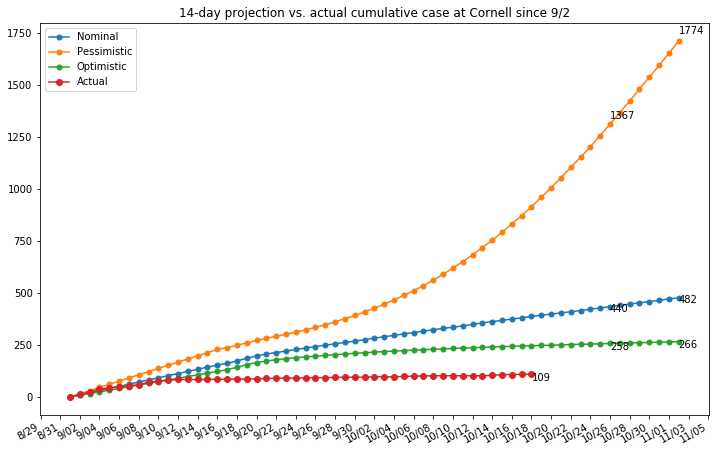

In [103]:
# Cornell_since_92=Cornell_so_far[d_start:]-Cornell_so_far[d_start]
# nominal_since_92 = nominal_final[d_start:]-nominal_final[d_start]
# opt_since_92 = opt_final[d_start:]-opt_final[d_start]
# pess_since_92 = pess_final[d_start:]-pess_final[d_start]

# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(dates[d_start:d_index_2w+1], nominal_since_92[:d_index_2w+1-d_start], '-o', label='Nominal',linewidth=1.5,markersize=5)
# ax.plot(dates[d_start:d_index_2w+1], pess_since_92[:d_index_2w+1-d_start], '-o', label='Pessimistic',linewidth=1.5,markersize=5)
# ax.plot(dates[d_start:d_index_2w+1], opt_since_92[:d_index_2w+1-d_start], '-o', label='Optimistic',linewidth=1.5,markersize=5)
# ax.plot(dates[d_start:d_index+1], Cornell_since_92, '-o', label='Actual')

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# ax.legend()
# ax.annotate(str(int(Cornell_since_92[-1])), (dates[d_index], Cornell_since_92[-1]-30))
# ax.annotate(str(int(nominal_since_92[d_index_2w+1-d_start])), (dates[d_index_2w], nominal_since_92[d_index_2w+1-d_start]-30))
# ax.annotate(str(int(opt_since_92[d_index_2w+1-d_start])), (dates[d_index_2w], opt_since_92[d_index_2w+1-d_start]-30))
# ax.annotate(str(int(pess_since_92[d_index_2w+1-d_start])), (dates[d_index_2w], pess_since_92[d_index_2w+1-d_start]-30))

# ax.annotate(str(int(nominal_since_92[d_index_2w+1-d_start-7])), (dates[d_index_2w-7], nominal_since_92[d_index_2w+1-d_start-7]-30))
# ax.annotate(str(int(opt_since_92[d_index_2w+1-d_start-7])), (dates[d_index_2w-7], opt_since_92[d_index_2w+1-d_start-7]-30))
# ax.annotate(str(int(pess_since_92[d_index_2w+1-d_start-7])), (dates[d_index_2w-7], pess_since_92[d_index_2w+1-d_start-7]-30))

# formatter = mdates.DateFormatter("%-m/%d")
# ax.xaxis.set_major_formatter(formatter)
# ax.set_xticks(ax.get_xticks()[::2])



# fig.autofmt_xdate()

# plt.title('14-day projection vs. actual cumulative case at Cornell since 9/2')

# plt.show()

#### Students

In [23]:
movein_selfiso_params = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]



g1_base_params_free  = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_pre_semester_private.yaml')[1]
g1_base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/group_1_students_post_movein_private.yaml')[1]

g2_base_params_free  = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_pre_semester_private.yaml')[1]
g2_base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/group_2_students_post_movein_private.yaml')[1]


g3_base_params_free  = load_params('../src/simulations_v2/params/jan4calibration/group_3_students_pre_semester_private.yaml')[1]
g3_base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/group_3_students_post_movein_private.yaml')[1]

#Load Actuals

actuals1 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_1.csv')
actuals2 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_2.csv')
actuals3 = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_3.csv')


actual_counts1 = actuals1['cum_case_count']
actual_counts2 = actuals2['cum_case_count']
actual_counts3 = actuals3['cum_case_count']


g1_movein_contact_matrix = np.matrix([
    [g1_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g2_movein_contact_matrix = np.matrix(
   [ [g2_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g3_movein_contact_matrix = np.matrix(
   [ [g3_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [39]:
total_infections([result[0][0], result[1][0], result[2][0]])
# len(actual_counts1)

563

In [46]:
np.random.seed(2060)

limited_policies = [[1/7,1/7,1/7],
[2/7,1/7,1/7],
[2/7,2/7,1/7],
[2/7,2/7,2/7],
[3/7,2/7,1/7],
[3/7,2/7,2/7],
[3/7,3/7,2/7]]

student_results = list()

for policy in limited_policies:
    print(policy)
    policy_trajs = sample_trajectories(0.465,100, test_policy = policy)
    student_results.append(policy_trajs)

[0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
0.465
[0.2857142857142857, 0.14285714285714285, 0.14285714285714285]
0.465
[0.2857142857142857, 0.2857142857142857, 0.14285714285714285]
0.465
[0.2857142857142857, 0.2857142857142857, 0.2857142857142857]
0.465
[0.42857142857142855, 0.2857142857142857, 0.2857142857142857]
0.465
[0.42857142857142855, 0.42857142857142855, 0.2857142857142857]
0.465


#### Faculty/Staff

In [47]:
base_params_free = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_post_movein_private.yaml')[1]
base_params_selfiso = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_pre_semester_private.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [48]:
outside_infection_week = pd.read_csv('outside_infection_staff.csv')
outside_infection_week = outside_infection_week.drop('Unnamed: 0', axis = 1)

weeks = list(outside_infection_week['week'].values)
cases = [0,
0,
0,
0,
1,
0,
0,
4,
7,
1,
9,
6,
9,
14,
12,
23,
22,
19,
23,
12]

# quick patch since last week is january
import datetime
print(datetime.datetime(2021,1,4).isocalendar()[1])

weeks.append(1)
cases.append(22)
outside_infection_week = pd.DataFrame(np.column_stack((weeks,cases)), columns = ['week','new_weekly_cases'])
outside_infection_week['new_weekly_cases'] = outside_infection_week['new_weekly_cases']/(7*(10283))

FileNotFoundError: [Errno 2] File outside_infection_staff.csv does not exist: 'outside_infection_staff.csv'

In [ ]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 10283 
base_params_free['test_population_fraction'] = 0 
base_params_free['test_protocol_QFNR'] =.43

# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
#base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] =0.098 #weighted average for students, weighted average for faculty and staff
base_params_free['test_protocol_QFNR'] = .43
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 10283
new_population_counts = [int(count) for count in """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])

from dynamic_population_sim import DynamicPopulationSim

def init_movein_sim(transmissions_per_contact, isolations_per_trace=None, outside_infection_week = None, test_freq):
    avg_init_cases = 0
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['outside_infection_p_array'] = outside_infection_week
    base_params_post_movein['test_population_fraction'] = test_freq
    
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
        base_params_post_movein['cases_isolated_per_contact']=isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
        
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [ ]:
import pandas as pd

def sample_movein_trajectory(transmission_p, isos_per_trace=None,outside_infection_week = None, T=112, test_freq=0.09807692307692308):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace,outside_infection_week, test_freq)
    # for each day
    for i in range(T):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return df

def sample_trajectories(transmission_p, ntrajectories, isos_per_trace=None, outside_infection_week = None, test_freq=0.09807692307692308):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_movein_trajectory(transmission_p, isos_per_trace,outside_infection_week, test_freq)
        trajectories.append(t)
    return trajectories

In [ ]:
test_freqs = [1/14, 0.09807692307692308, 1/7]

staff_results = list()

for test_freq in test_freqs:
    print(test_freq)
    policy_trajs = sample_trajectories(0.015,100)
    staff_results.append(policy_trajs)

# Correlation Graphs

In [322]:
np.random.seed(2070)
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

inperson_normal = list()
print('Evaluating this policy: ', testing_policy)

params_list, interaction_matrix, group_names = get_nominal_params()

tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 1)
inperson_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [323]:
np.random.seed(2070)
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]


# optimistic, nominal, pessimistic
# 0.5x -> 2x transmission rate matrix
# scale: all, student, faculty/staff

params_config = list()
cornell_inf = list()
cornell_hosp = list()
ithaca_inf = list()
ithaca_hosp = list()


for scenario in ['optimistic', 'nominal', 'pessimistic']:
    if scenario in ['optimistic', 'nominal']:
        tr_mult_array = np.linspace(0.5,2,16)
    else:
        tr_mult_array = np.linspace(0.5,1,6)
    for tr_mult in tr_mult_array:
        for scale in ['all', 'students', 'staff']:
            if scenario == 'optimistic':
                params_list, interaction_matrix, group_names = get_optimistic_params()
            elif scenario == 'nominal':
                params_list, interaction_matrix, group_names = get_nominal_params()
            else:
                params_list, interaction_matrix, group_names = get_pessimistic_params()

            if scale == 'all':
                interaction_matrix *= tr_mult
            elif scale == 'students':
                for i in range(4):
                    for j in range(4):
                        interaction_matrix[i,j] *= tr_mult
            else:
                for i in range(4,7):
                    for j in range(4,7):
                        interaction_matrix[i,j] *= tr_mult

            tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 1)
            params_config.append((scenario, tr_mult, scale))
            cornell_inf.append(np.sum(inf_matrix[0][:-1]))
            cornell_hosp.append(np.sum(hosp_matrix[0][:-1]))
            ithaca_inf.append(inf_matrix[0][-1])
            ithaca_hosp.append(hosp_matrix[0][-1])
        

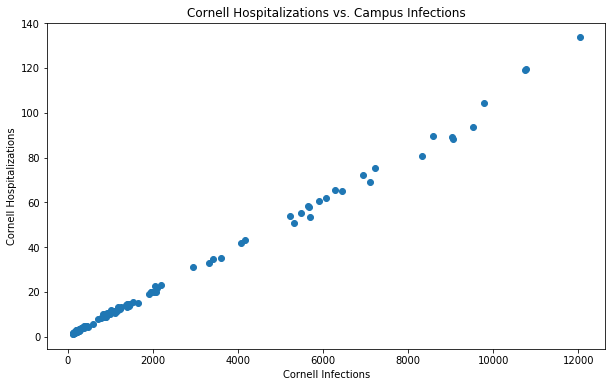

In [123]:
plt.figure(figsize=(10,6))
plt.scatter(cornell_inf, cornell_hosp)
plt.title('Cornell Hospitalizations vs. Campus Infections')
plt.xlabel('Cornell Infections')
plt.ylabel('Cornell Hospitalizations')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/cornell_hosp_corr.png', dpi=450)

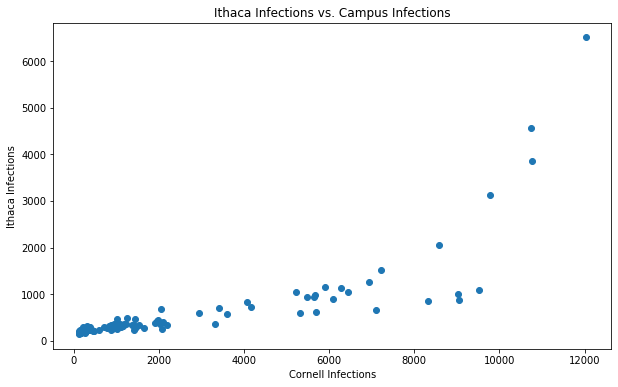

In [124]:
plt.figure(figsize=(10,6))
plt.scatter(cornell_inf, ithaca_inf)
plt.title('Ithaca Infections vs. Campus Infections')
plt.xlabel('Cornell Infections')
plt.ylabel('Ithaca Infections')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/ithaca_inf_corr.png', dpi=450)

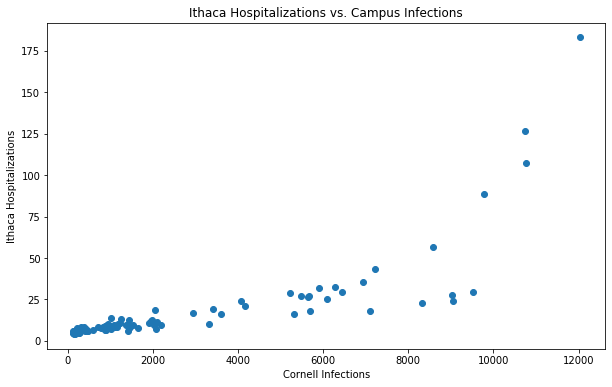

In [125]:
plt.figure(figsize=(10,6))
plt.scatter(cornell_inf, ithaca_hosp)
plt.title('Ithaca Hospitalizations vs. Campus Infections')
plt.xlabel('Cornell Infections')
plt.ylabel('Ithaca Hospitalizations')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/ithaca_hosp_corr.png', dpi=450)

# Calibration

### Staff Calibration

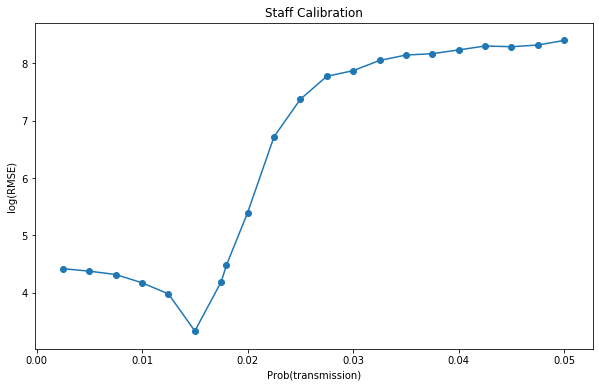

In [144]:
FS_RMSE_data = pd.read_csv('res_inst_paper_graphs/mar_19_graphs/FS_results.csv', index_col=0)
# FS_RMSE_data

plt.figure(figsize=(10,6))
plt.plot('transmission_p', 'score', data = FS_RMSE_data)
plt.scatter('transmission_p', 'score', data = FS_RMSE_data)
plt.title('Staff Calibration')
plt.xlabel('Prob(transmission)')
plt.ylabel('log(RMSE)')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/FS_calibration_RMSE.png', dpi=450)

In [223]:
FS_RMSE_data

,transmission_p,score
0,0.0025,4.421239
1,0.0050,4.377592
2,0.0075,4.319410
3,0.0100,4.174787
4,0.0125,3.980806
5,0.0150,3.333723
6,0.0175,4.192880
7,0.0180,4.485052
8,0.0200,5.397188
9,0.0225,6.719922


### Student Calibration

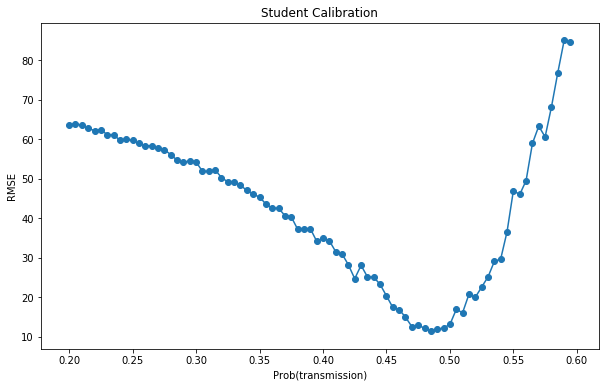

In [146]:
student_RMSE_data = pd.read_csv('res_inst_paper_graphs/mar_19_graphs/students_to_plot.csv', index_col=0)

plt.figure(figsize=(10,6))
plt.plot('inputs', 'RMSE', data = student_RMSE_data)
plt.scatter('inputs', 'RMSE', data = student_RMSE_data)
plt.title('Student Calibration')
plt.xlabel('Prob(transmission)')
plt.ylabel('RMSE')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/student_calibration_RMSE.png', dpi=450)

In [150]:
student_RMSE_data.sort_values('RMSE')

,inputs,RMSE
57,0.485,11.463396
58,0.490,11.916088
56,0.480,12.176163
59,0.495,12.230833
54,0.470,12.588380
...,...,...
1,0.205,63.992380
76,0.580,68.218467
77,0.585,76.889550
79,0.595,84.618470


### Case counts per group

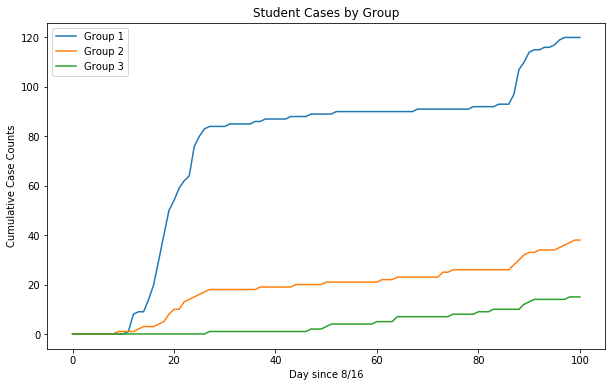

In [184]:
# folder: https://github.com/peter-i-frazier/group-testing/tree/master/src/simulations_v2/params/jan4calibration

group_1_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_1.csv')
group_2_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_2.csv')
group_3_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_3.csv')

plt.figure(figsize=(10,6))
plt.plot(group_1_cum_cases[['cum_case_count']], label='Group 1')
plt.plot(group_2_cum_cases[['cum_case_count']], label='Group 2')
plt.plot(group_3_cum_cases[['cum_case_count']], label='Group 3')

plt.legend()

plt.title('Student Cases by Group')
plt.xlabel('Day since 8/16')
plt.ylabel('Cumulative Case Counts')

plt.savefig('res_inst_paper_graphs/mar_19_graphs/student_actual_cases.png', dpi=450)

### Student Trajectories

In [185]:
import pickle

In [203]:
trajectories = pickle.load( open( "res_inst_paper_graphs/mar_19_graphs/group_trajectories.p", "rb" ) )
# actuals = pickle.load( open( "res_inst_paper_graphs/mar_19_graphs/actuals.p", "rb" ) )

##### Group 1

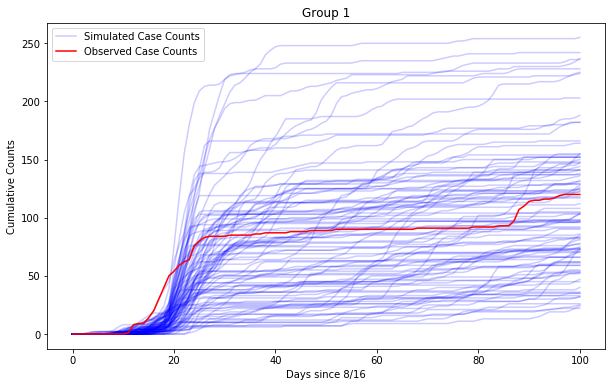

In [209]:
plt.figure(figsize=(10,6))
sim_label='Simulated Case Counts'
for group_traj in trajectories[0]:
    plt.plot(group_traj, alpha=0.2, color='blue', label=sim_label)
    sim_label=None

group_1_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_1.csv')
plt.plot(group_1_cum_cases['cum_case_count'], color='red', label='Observed Case Counts')
plt.legend()

plt.title('Group 1')
plt.xlabel('Days since 8/16')
plt.ylabel('Cumulative Counts')

# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/group_1_calibration.png', dpi=450)

##### Group 2

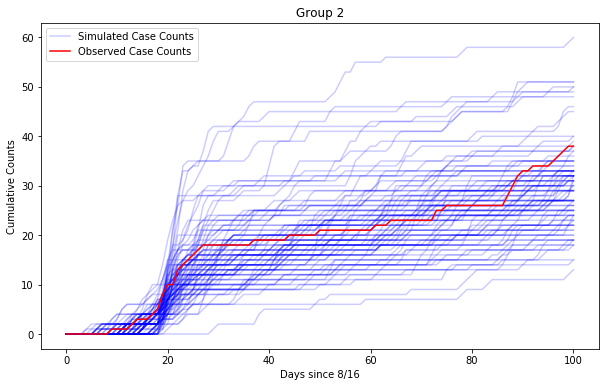

In [211]:
plt.figure(figsize=(10,6))
sim_label='Simulated Case Counts'
for group_traj in trajectories[1]:
    plt.plot(group_traj, alpha=0.2, color='blue', label=sim_label)
    sim_label=None

group_2_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_2.csv')
plt.plot(group_2_cum_cases['cum_case_count'], color='red', label='Observed Case Counts')
plt.legend()

plt.title('Group 2')
plt.xlabel('Days since 8/16')
plt.ylabel('Cumulative Counts')

# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/group_2_calibration.png', dpi=450)

##### Group 3

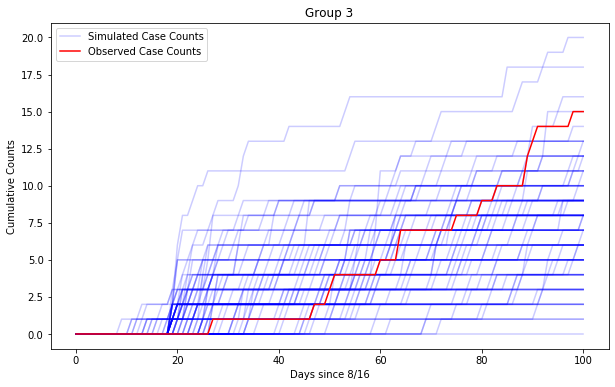

In [213]:
plt.figure(figsize=(10,6))
sim_label='Simulated Case Counts'
for group_traj in trajectories[2]:
    plt.plot(group_traj, alpha=0.2, color='blue', label=sim_label)
    sim_label=None

group_3_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_3.csv')
plt.plot(group_3_cum_cases['cum_case_count'], color='red', label='Observed Case Counts')
plt.legend()

plt.title('Group 3')
plt.xlabel('Days since 8/16')
plt.ylabel('Cumulative Counts')

# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/group_3_calibration.png', dpi=450)

# Faculty/Staff Case Counts + Trajectories

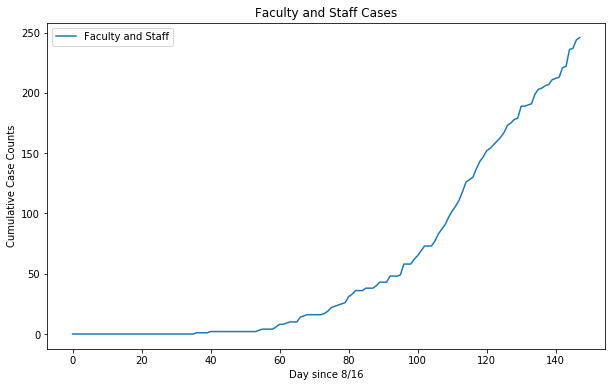

In [215]:
# folder: https://github.com/peter-i-frazier/group-testing/tree/master/src/simulations_v2/params/jan4calibration

group_4_cum_cases = pd.read_csv('../src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')

plt.figure(figsize=(10,6))
plt.plot(group_4_cum_cases[['cum_case_count']], label='Faculty and Staff')

plt.legend()

plt.title('Faculty and Staff Cases')
plt.xlabel('Day since 8/16')
plt.ylabel('Cumulative Case Counts')

plt.savefig('res_inst_paper_graphs/mar_19_graphs/faculty_staff_actual_cases.png', dpi=450)

In [227]:
FS_trajs = pd.read_csv('res_inst_paper_graphs/mar_19_graphs/FS_Timeseries.csv')
FS_trajs

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,p
0,0,0,0,0,0,0,0,0,0,0,...,32,32,32,33,33,33,33,33,33,0.0025
1,1,0,0,0,0,0,0,0,0,0,...,29,29,29,29,29,29,29,30,30,0.0025
2,2,0,0,0,0,0,0,0,0,0,...,25,25,26,26,26,26,27,27,27,0.0025
3,3,0,0,0,0,0,0,0,0,0,...,18,18,18,19,19,19,19,19,19,0.0025
4,4,0,0,0,0,0,0,0,0,0,...,25,25,25,25,25,25,25,26,26,0.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,15,0,0,0,0,0,0,0,0,0,...,7109,7115,7128,7138,7143,7153,7161,7167,7176,0.0500
416,16,0,0,0,0,0,0,0,0,0,...,7165,7175,7190,7204,7213,7226,7236,7245,7258,0.0500
417,17,0,0,0,0,0,0,0,0,0,...,7064,7073,7088,7102,7119,7133,7153,7168,7183,0.0500
418,18,0,0,0,0,0,0,0,0,0,...,7079,7084,7096,7102,7109,7124,7139,7156,7169,0.0500


# Sensitivity Analysis

Parameters to vary: Daily self-reporting prob, asymptomatic percent, test FNR, test compliance, outside infection mult

In [52]:
def get_nominal_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/nominal/'
    
    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    return params_list, interaction_matrix, group_names

In [53]:
def get_optimistic_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/optimistic/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/optimistic/'

    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]
    
    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    
    return params_list, 0.7*interaction_matrix, group_names

In [54]:
def get_pessimistic_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/pessimistic/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/pessimistic/'

    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]
    
    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    
    return params_list, 1.3*interaction_matrix, group_names

In [431]:
get_nominal_params()[0][0]

{'severity_prevalence': array([0.52 , 0.472, 0.006, 0.002]),
 'population_size': 4167,
 'initial_ID_prevalence': 0.001558,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'exposed_infection_p': 0.018,
 'expected_contacts_per_day': 12.5,
 'daily_outside_infection_p': 1.2e-05,
 'mild_symptoms_daily_self_report_p': 0,
 'severe_symptoms_daily_self_report_p': 0.22,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<

### Daily Self reporting prob

In [450]:
def self_reporting_sensitivity():

    self_report_list = [0.1, 0.15, 0.2, 0.22, 0.25, 0.3, 0.4, 0.5]

    nominal_results = list()
    optimistic_results = list()
    pessimistic_results = list()

    testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

    for self_report_prob in self_report_list:
        print('Evaluating this prob: ', self_report_prob)
        nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
        optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
        pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
        for param_config in nominal_params_list:
            param_config['severe_symptoms_daily_self_report_p'] = self_report_prob
        for param_config in optimistic_params_list:
            param_config['severe_symptoms_daily_self_report_p'] = self_report_prob
        for param_config in pessimistic_params_list:
            param_config['severe_symptoms_daily_self_report_p'] = self_report_prob

    #     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
        nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
        nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
        optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
        pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})

    plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
    plotting_data_nominal_results['self_report_prob'] = self_report_list
    plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
    plotting_data_optimistic_results['self_report_prob'] = self_report_list
    plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
    plotting_data_pessimistic_results['self_report_prob'] = self_report_list

    return plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results

### Asymptomatic Percent

In [432]:
def modify_severity(array, asympt_mult):
    total_sympt = np.sum(array[1:])
    new_sympt = 1 - array[0] * asympt_mult
    array[0] *= asympt_mult
    array[1] *= new_sympt/total_sympt
    array[2] *= new_sympt/total_sympt
    array[3] *= new_sympt/total_sympt
    return array

In [436]:
modify_severity(np.array([0.52 , 0.472, 0.006, 0.002]), 0.5)

array([0.26      , 0.72766667, 0.00925   , 0.00308333])

In [451]:
def asymp_p_sensitivity():

    asymp_p_mult = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

    nominal_results = list()
    optimistic_results = list()
    pessimistic_results = list()

    testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

    for asymp_p in asymp_p_mult:
        print('Evaluating this asymp mult: ', asymp_p)
        nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
        optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
        pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
        for param_config in nominal_params_list:
            param_config['severity_prevalence'] = modify_severity(param_config['severity_prevalence'], asymp_p)
        for param_config in optimistic_params_list:
            param_config['severity_prevalence'] = modify_severity(param_config['severity_prevalence'], asymp_p)
        for param_config in pessimistic_params_list:
            param_config['severity_prevalence'] = modify_severity(param_config['severity_prevalence'], asymp_p)

    #     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
        nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
        nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
        optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
        pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})

    plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
    plotting_data_nominal_results['asymp_p_mult'] = asymp_p_mult
    plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
    plotting_data_optimistic_results['asymp_p_mult'] = asymp_p_mult
    plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
    plotting_data_pessimistic_results['asymp_p_mult'] = asymp_p_mult

    return plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results

### Test Sensitivity

In [452]:
def get_test_FNR(sensitivity, compliance):
    return 1 - (sensitivity * compliance)

def test_sensitivity_sensitivity():

    test_sensitivity_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

    nominal_results = list()
    optimistic_results = list()
    pessimistic_results = list()

    testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

    for sensitivity in test_sensitivity_list:
        print('Evaluating this sensitivty: ', sensitivity)
        nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
        optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
        pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
        for param_config in nominal_params_list:
            param_config['test_protocol_QFNR'] = get_test_FNR(sensitivity, 0.9)
        for param_config in optimistic_params_list:
            param_config['test_protocol_QFNR'] = get_test_FNR(sensitivity, 0.9)
        for param_config in pessimistic_params_list:
            param_config['test_protocol_QFNR'] = get_test_FNR(sensitivity, 0.9)

    #     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
        nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
        nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
        optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
        pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})

    plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
    plotting_data_nominal_results['test_sensitivity'] = test_sensitivity_list
    plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
    plotting_data_optimistic_results['test_sensitivity'] = test_sensitivity_list
    plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
    plotting_data_pessimistic_results['test_sensitivity'] = test_sensitivity_list

    return plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results

### Test Compliance

In [453]:
def test_compliance_sensitivity():

    test_compliance_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

    nominal_results = list()
    optimistic_results = list()
    pessimistic_results = list()

    testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

    for compliance in test_compliance_list:
        print('Evaluating this compliance: ', compliance)
        nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
        optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
        pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
        for param_config in nominal_params_list:
            param_config['test_protocol_QFNR'] = get_test_FNR(0.6, compliance)
        for param_config in optimistic_params_list:
            param_config['test_protocol_QFNR'] = get_test_FNR(0.7, compliance)
        for param_config in pessimistic_params_list:
            param_config['test_protocol_QFNR'] = get_test_FNR(0.5, compliance)

    #     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
        nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
        nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
        optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
        pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})

    plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
    plotting_data_nominal_results['test_compliance'] = test_compliance_list
    plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
    plotting_data_optimistic_results['test_compliance'] = test_compliance_list
    plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
    plotting_data_pessimistic_results['test_compliance'] = test_compliance_list

    return plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results

### Outside Infections

In [468]:
def outside_infection_sensitivity():

    outside_inf_mults = [0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4]

    nominal_results = list()
    optimistic_results = list()
    pessimistic_results = list()

    testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

    for outside_inf_mult in outside_inf_mults:
        print('Evaluating this mult: ', outside_inf_mult)
        nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
        optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
        pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
        for param_config in nominal_params_list:
            param_config['daily_outside_infection_p'] *= outside_inf_mult
        for param_config in optimistic_params_list:
            param_config['daily_outside_infection_p'] *= outside_inf_mult
        for param_config in pessimistic_params_list:
            param_config['daily_outside_infection_p'] *= outside_inf_mult

    #     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
        nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
        nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
        optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
        pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})

    plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
    plotting_data_nominal_results['outside_inf_mult'] = outside_inf_mults
    plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
    plotting_data_optimistic_results['outside_inf_mult'] = outside_inf_mults
    plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
    plotting_data_pessimistic_results['outside_inf_mult'] = outside_inf_mults

    return plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results

### Contact Tracing Delay

In [51]:
def ct_delay_sensitivity():

    ct_delays = [0, 1, 2, 3, 4, 5, 6, 7]

    nominal_results = list()
    optimistic_results = list()
    pessimistic_results = list()

    testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

    for ct_delay in ct_delays:
        print('Evaluating this delay: ', ct_delay)
        nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
        optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
        pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
        for param_config in nominal_params_list:
            param_config['contact_tracing_delay'] *= ct_delay
        for param_config in optimistic_params_list:
            param_config['contact_tracing_delay'] *= ct_delay
        for param_config in pessimistic_params_list:
            param_config['contact_tracing_delay'] *= ct_delay

    #     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
        nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
        nominal_results.append({'test_policy': testing_policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
        optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        optimistic_results.append({'test_policy': testing_policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
        pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
        pessimistic_results.append({'test_policy': testing_policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})

    plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
    plotting_data_nominal_results['ct_delay'] = ct_delays
    plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
    plotting_data_optimistic_results['ct_delay'] = ct_delays
    plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
    plotting_data_pessimistic_results['ct_delay'] = ct_delays

    return plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results

In [57]:
from multiprocessing import Process

def sim_target_f(f, pickle_file_loc):
    results = f()
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(f, pickle_file_loc):
    p = Process(target = sim_target_f, args = (f, pickle_file_loc))
    p.start()
    return p


In [60]:
import pickle
# # base_transmission_p = 0.465/10
# transmission_ps_to_try = np.arange(1, 3.5, 0.05)

# output_dir = "apr_4_multigroup_sim_results_spring/"
# ntrajectories = 200

processes = []
# p = run_sims_new_process(self_reporting_sensitivity, 'res_inst_paper_graphs/apr_5_sens_self_report.dill')
# processes.append(p)
# p = run_sims_new_process(asymp_p_sensitivity, 'res_inst_paper_graphs/apr_5_sens_asymp_p.dill')
# processes.append(p)
# p = run_sims_new_process(test_sensitivity_sensitivity, 'res_inst_paper_graphs/apr_5_sens_test_sensitivity.dill')
# processes.append(p)
# p = run_sims_new_process(test_compliance_sensitivity, 'res_inst_paper_graphs/apr_5_sens_test_compliance.dill')
# processes.append(p)
# p = run_sims_new_process(outside_infection_sensitivity, 'res_inst_paper_graphs/apr_5_sens_outside_inf_sensitivity.dill')
# processes.append(p)
p = run_sims_new_process(ct_delay_sensitivity, 'res_inst_paper_graphs/apr_5_sens_ct_delay.dill')
processes.append(p)


# for tr_mult in transmission_ps_to_try:
#     filename = output_dir + "tr_mult_{}.pickle".format(tr_mult)
#     p = run_sims_new_process(tr_mult, ntrajectories, filename)
#     processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

Evaluating this delay:  0


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


launched 1 processes
Evaluating this delay:  1
Evaluating this delay:  2
Evaluating this delay:  3
Evaluating this delay:  4
Evaluating this delay:  5
Evaluating this delay:  6
Evaluating this delay:  7


#### Daily Self reporting prob

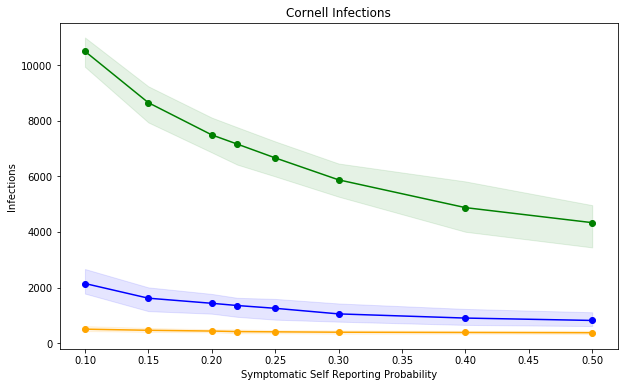

In [474]:
file = open('res_inst_paper_graphs/apr_5_sens_self_report.dill', mode='rb')
[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results] = dill.load(file)
file.close()

plt.figure(figsize=(10,6))

# plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['self_report_prob']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='self_report_prob', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['self_report_prob']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='self_report_prob', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['self_report_prob']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='self_report_prob', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Symptomatic Self Reporting Probability')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_self_reporting_prob.png', dpi=450)

#### Asymptomatic Percent

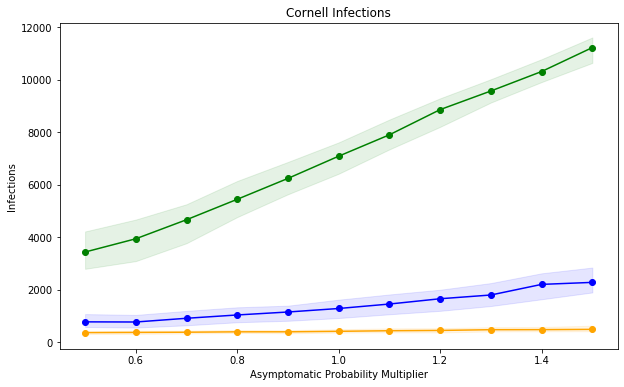

In [461]:
file = open('res_inst_paper_graphs/apr_5_sens_asymp_p.dill', mode='rb')
[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results] = dill.load(file)
file.close()

plt.figure(figsize=(10,6))

# plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['asymp_p_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='asymp_p_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['asymp_p_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='asymp_p_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['asymp_p_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='asymp_p_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Asymptomatic Probability Multiplier')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_asymp_p.png', dpi=450)

#### Test Sensitivity

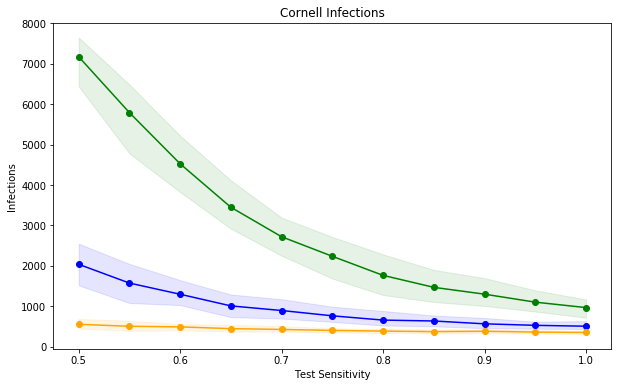

In [472]:
file = open('res_inst_paper_graphs/apr_5_sens_test_sensitivity.dill', mode='rb')
[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results] = dill.load(file)
file.close()

plt.figure(figsize=(10,6))

# plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['test_sensitivity']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='test_sensitivity', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['test_sensitivity']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='test_sensitivity', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['test_sensitivity']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='test_sensitivity', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Test Sensitivity')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_test_sensitivity.png', dpi=450)

#### Test Compliance

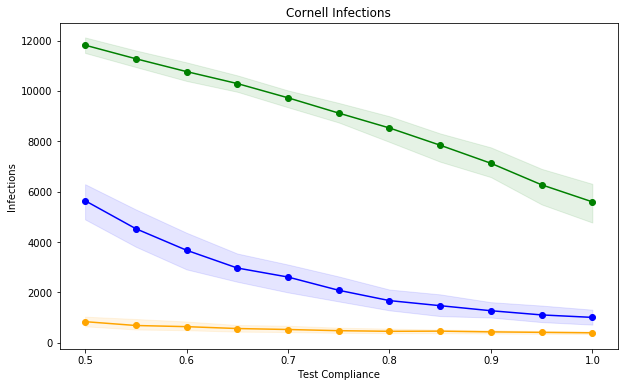

In [467]:
file = open('res_inst_paper_graphs/apr_5_sens_test_compliance.dill', mode='rb')
[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results] = dill.load(file)
file.close()

plt.figure(figsize=(10,6))

# plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['test_compliance']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='test_compliance', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['test_compliance']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='test_compliance', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['test_compliance']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='test_compliance', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Test Compliance')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_test_compliance.png', dpi=450)

#### Outside Infections

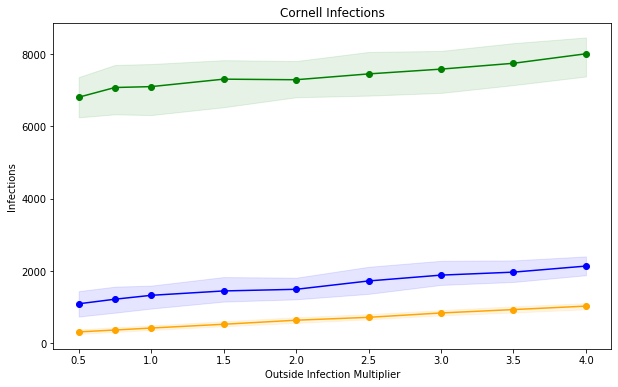

In [473]:
file = open('res_inst_paper_graphs/apr_5_sens_outside_inf_sensitivity.dill', mode='rb')
[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results] = dill.load(file)
file.close()

plt.figure(figsize=(10,6))

# plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['outside_inf_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='outside_inf_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['outside_inf_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='outside_inf_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['outside_inf_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='outside_inf_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Outside Infection Multiplier')
# plt.show()
plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_outside_inf.png', dpi=450)

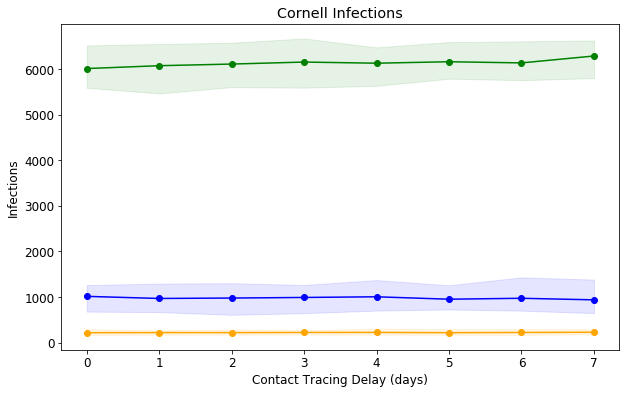

In [61]:
file = open('res_inst_paper_graphs/apr_5_sens_ct_delay.dill', mode='rb')
[plotting_data_nominal_results, plotting_data_optimistic_results, plotting_data_pessimistic_results] = dill.load(file)
file.close()

plt.figure(figsize=(10,6))

# plt.subplot(3, 1, 1)
plt.plot(plotting_data_nominal_results[['ct_delay']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='ct_delay', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['ct_delay']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='ct_delay', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['ct_delay']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='ct_delay', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Contact Tracing Delay (days)')
plt.show()
# plt.savefig('res_inst_paper_graphs/mar_19_graphs/sensitivity_analysis_outside_inf.png', dpi=450)